In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
from itertools import permutations
from collections import defaultdict
from matplotlib import animation
from JSAnimation.IPython_display import display_animation

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

In [2]:
def next_gen(cells, flags):
    next_cells = defaultdict(dict)
    for i in flags:
        next_cells[list(cells)[i]]['size'] = cells[list(cells)[i]]['size']
        next_cells[list(cells)[i]]['coords'] = cells[list(cells)[i]]['coords']
        next_cells[list(cells)[i]]['disc_weights'] = cells[list(cells)[i]]['disc_weights']    
    return(next_cells)

In [47]:
def extract_tribe(cells, labels, node_n = 225):
    stack = np.zeros((len(c), node_n))
    for i in range(0,len(c)):
        stack[i,] = list(c.values())[i]['disc_weights'].flatten()
    db = DBSCAN().fit(stack)
    result = []
    for k in labels:
        result = [result, [j for j, x in enumerate(db.labels_ == k) if x]]
    result = next_gen(cells, flags = result[1])
    return(result)

In [4]:
def slime(cells = None,
          start_pop = 100,
          fig_size = [5,5],
          border = 40,
          sight = 5,
          board_size = 100,
          max_hp = 6,
          baby_hp = 3,
          log = False,
          frames=200,
          interval=50,
          mode='once'):
    
    def sig_func(x,y):
        return(1/(1+np.exp(-(np.dot(x,y)))))

    # Funtion to build the initial cell list.  NN is built around sight/input of 5, movement/output of 3.
    def cell_list():
        start_coords = np.random.choice(range(border,board_size-border),start_pop*2)
        cells  = defaultdict(dict)
        for i in range(0,board_size,2):
            name = str(random.getrandbits(128))
            cells[name] = {}
            coords = [start_coords[i],start_coords[i+1]]
            disc_weights = 2*np.random.random((sight*sight,3*3))-1
            cells[name]['size'] = baby_hp
            cells[name]['coords'] = coords
            cells[name]['disc_weights'] = disc_weights
        return(cells)
    
    # Create the cell list.
    if(cells == None):
        cells = cell_list()

    # Create the board.
    X = np.zeros(shape=(board_size,board_size))
    
    # initialization function: plot the background of each frame
    def init():
        im.set_data(X)
        return (im,)
    
    # Get the coodinates for the input.
    L = [0, 0, 1, 1, -1, -1, 2, 2, -2, -2]
    keep = [0,0]
    for comb in permutations(L, r=2):
        keep = np.vstack((keep, comb))
    
    # Setup plotting.
    fig = plt.figure(figsize=fig_size)
    ax = fig.add_axes([0, 0, 1, 1], xticks=[], yticks=[], frameon=False)
    im = ax.imshow(X, cmap='hot', interpolation='nearest')
    im.set_clim(0, 8)

    def animate(i):
        # Take turns through the cell list.
        im.set_data(animate.X)
        for i in list(cells):
            # Input.
            test_in = []
            for perm in np.mod(cells[i]['coords'] + np.unique(keep,axis=0), board_size):
                test_in = np.append(test_in,X[perm[0],perm[1]])
            # Output.
            test_out = sig_func(test_in,cells[i]['disc_weights'])
            d = test_out.argmin()
            
            # Stay and Grow.
            if(d==4):               
                if(cells[i]['size'] < max_hp):
                    cells[i]['size'] += 1
                    if(log == True):
                        print("{0} grew to size {1}.".format(i, cells[i]['size']))
            # Move.
            else:
                if(d==0):
                    new_coord = [-1,1]
                if(d==1):
                    new_coord = [0,1]
                if(d==2):
                    new_coord = [1,1]
                if(d==3):
                    new_coord = [-1,0]
                if(d==5):
                    new_coord = [1,0]
                if(d==6):
                    new_coord = [-1,-1]
                if(d==7):
                    new_coord = [0,-1]
                if(d==8):
                    new_coord = [1,-1]
                    
                # Split.
                if(cells[i]['size'] >= max_hp):
                    # Half its size.
                    cells[i]['size'] = baby_hp
                    # Give the baby attributes and mutate the NN.
                    baby_name = str(random.getrandbits(128))
                    cells[baby_name]['size'] = cells[i]['size']
                    cells[baby_name]['coords'] = cells[i]['coords']
                    cells[baby_name]['disc_weights'] = cells[i]['disc_weights']
                    cells[baby_name]['disc_weights'][np.random.choice(sight*sight),
                                                     np.random.choice(3*3)] == 2*np.random.random(1)-1
                    if(log == True):
                        print("{0} underwent mitosis.  Gave birth to {1}.".format(i, baby_name))

                # If it moved.
                if(X[np.mod(np.add(cells[i]['coords'], new_coord), board_size)[0],
                     np.mod(np.add(cells[i]['coords'], new_coord), board_size)[1]] == 0):
                    # Clear where it was.
                    X[cells[i]['coords'][0],cells[i]['coords'][1]] = 0
                    # Give new coordinate and fill it in.
                    cells[i]['coords'] = np.mod(np.add(cells[i]['coords'], new_coord), board_size)
                    X[cells[i]['coords'][0],cells[i]['coords'][1]] = abs(sum(sum(cells[i]['disc_weights'])))

                else:
                    # It gets bumped.
                    cells[i]['size'] -= 1
                    if(log == True):
                        print("{0} was injured to size {1}!".format(i, cells[i]['size']))
                    # Handle death.
                    if(cells[i]['size'] < 1):
                        try:
                            # Clear where it was and delete from list.
                            X[cells[i]['coords'][0],cells[i]['coords'][1]] = 0
                            del cells[i]
                            if(log == True):
                                print("{0} died!.".format(i))
                        except KeyError:
                            pass
                        
        return (im,)
        
    animate.X = X
    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=frames, interval=interval)
    
    return (display_animation(anim, default_mode=mode),cells)


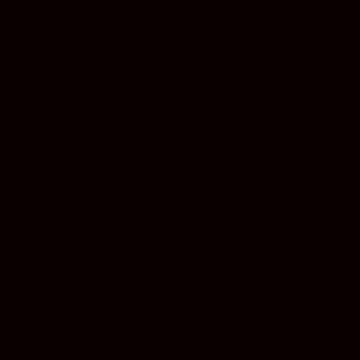
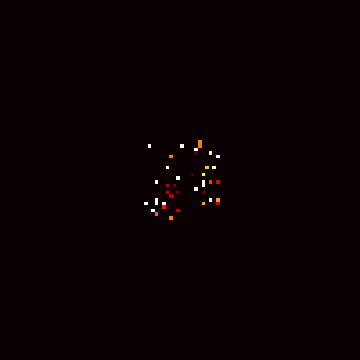
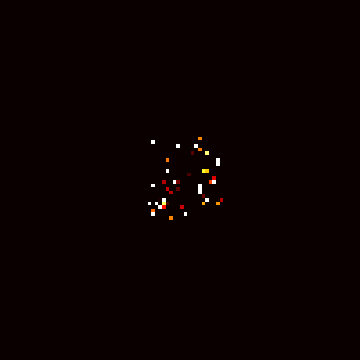
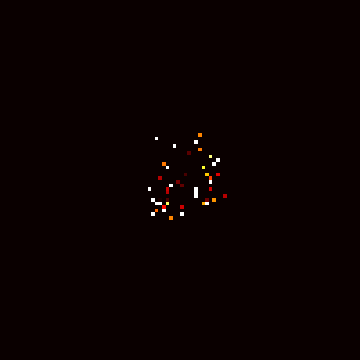
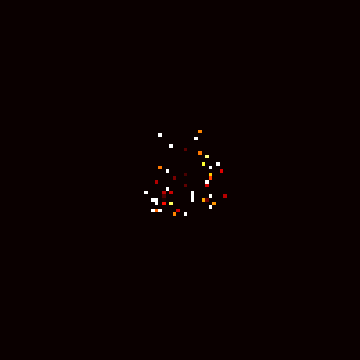
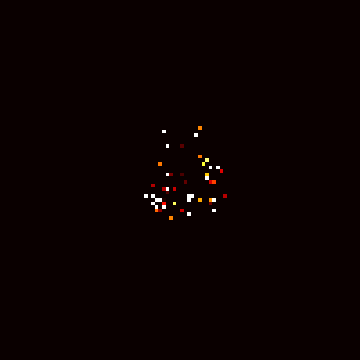
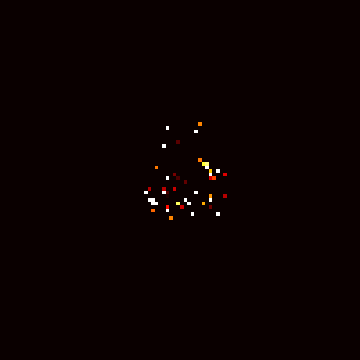
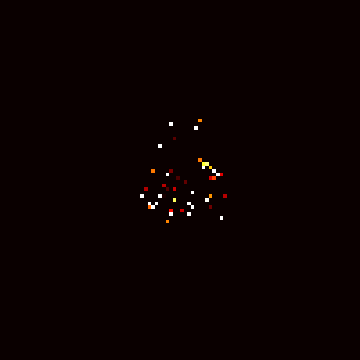
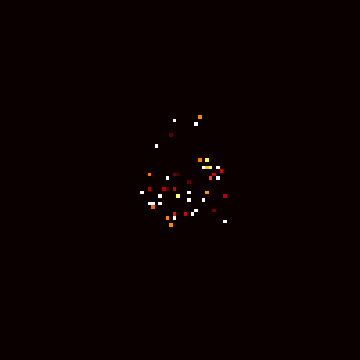
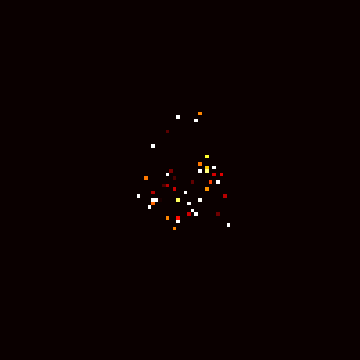
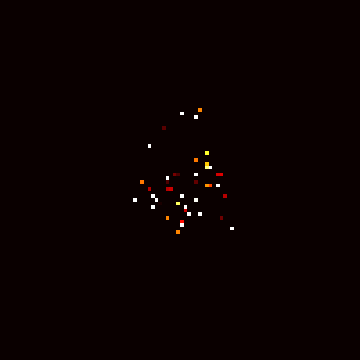
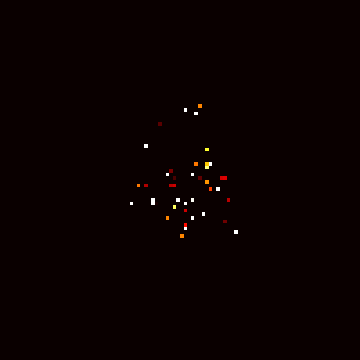
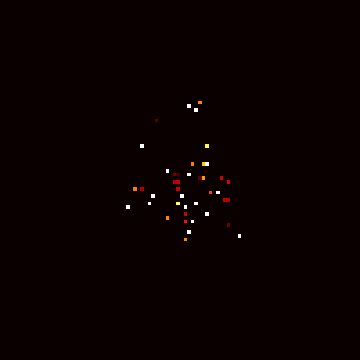
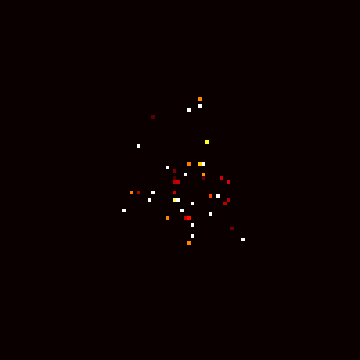
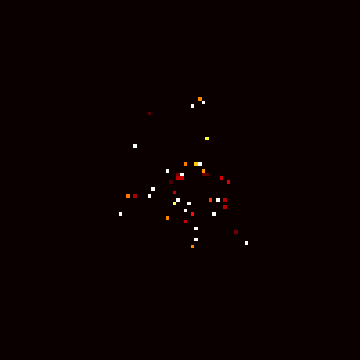
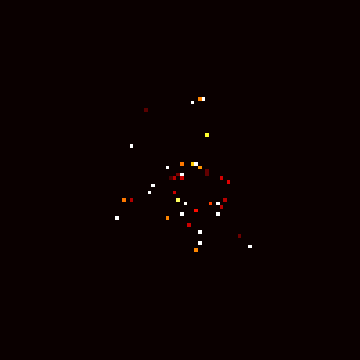
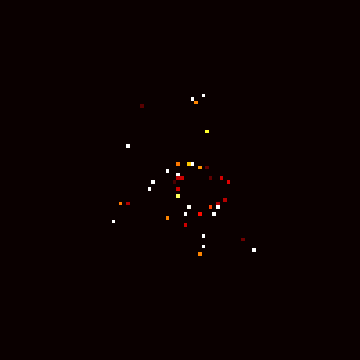
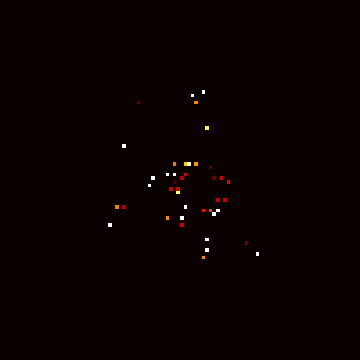
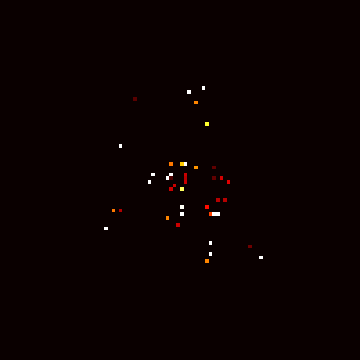
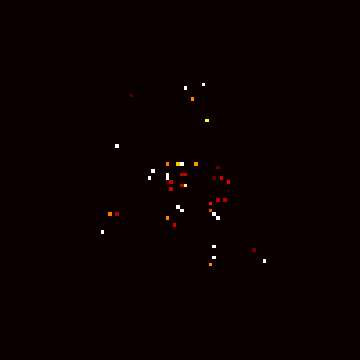
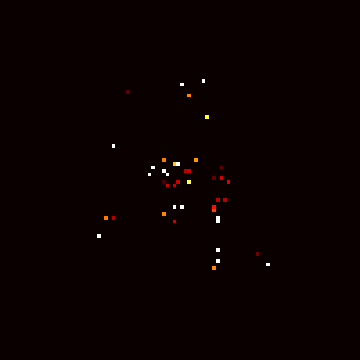
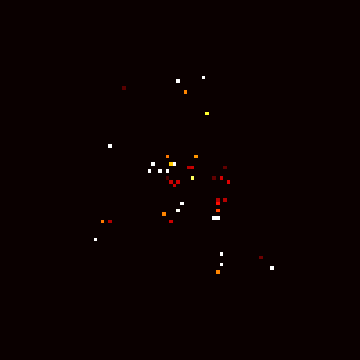
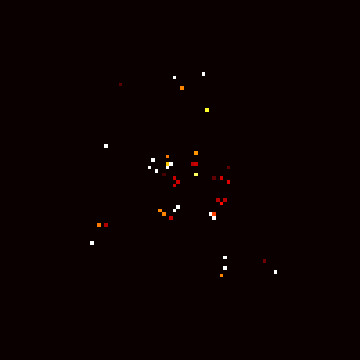
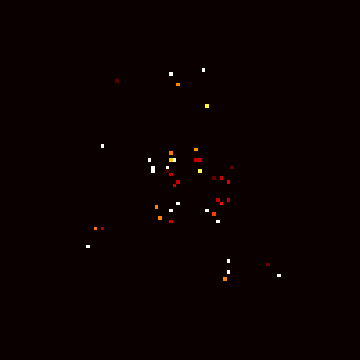
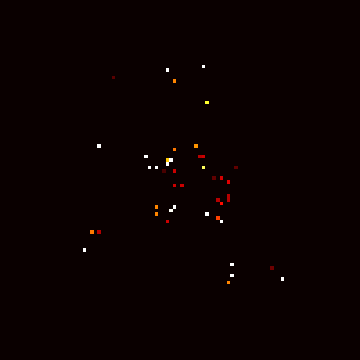
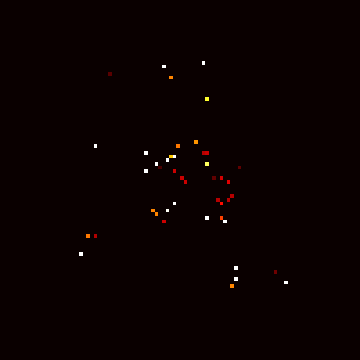
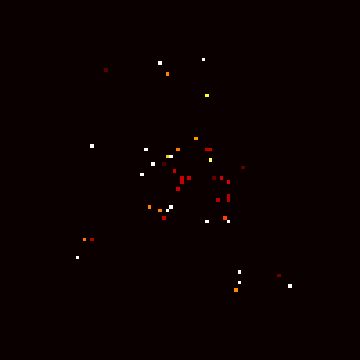
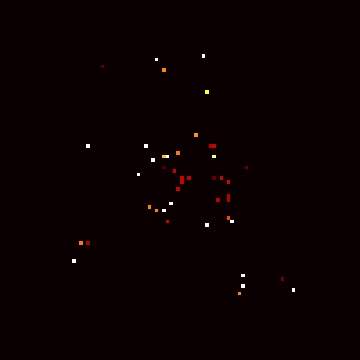
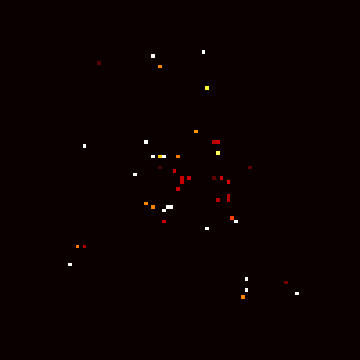
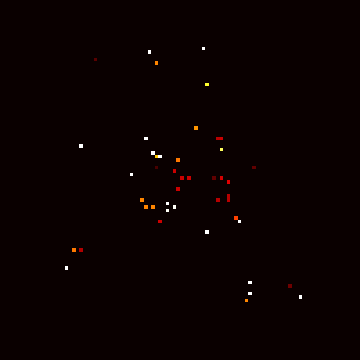
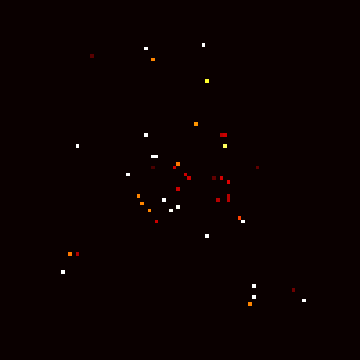
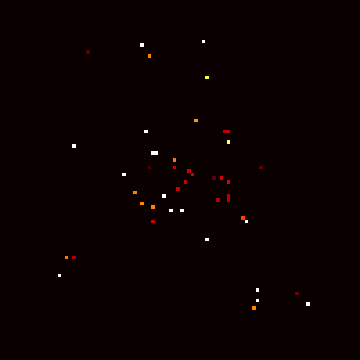
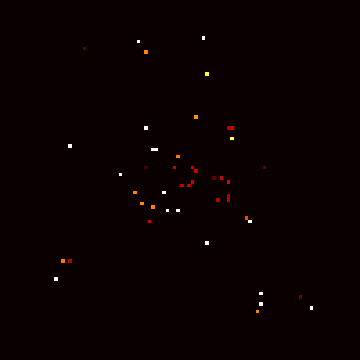
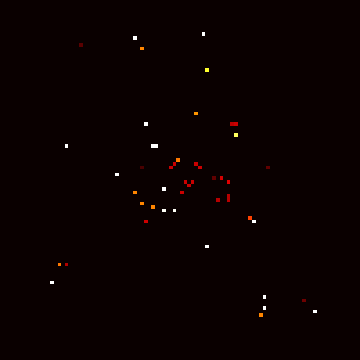
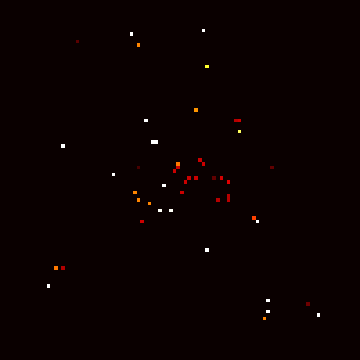
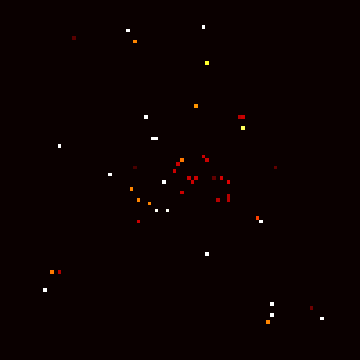
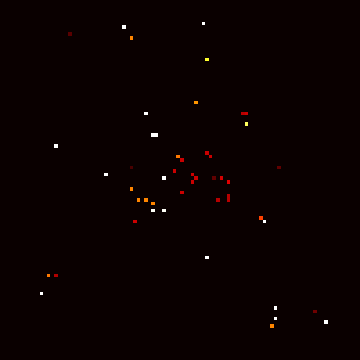
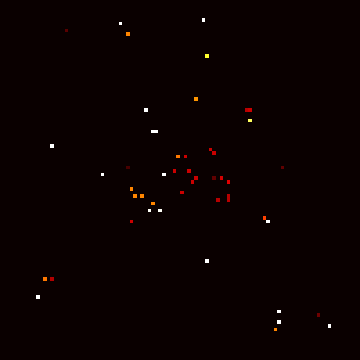
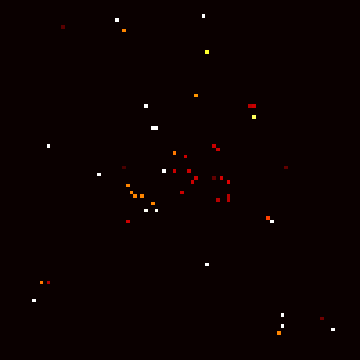
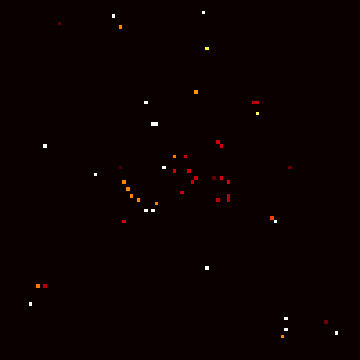
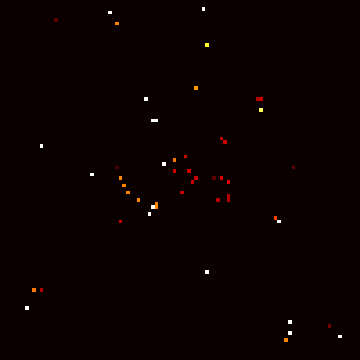
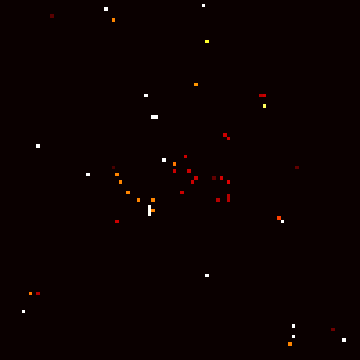
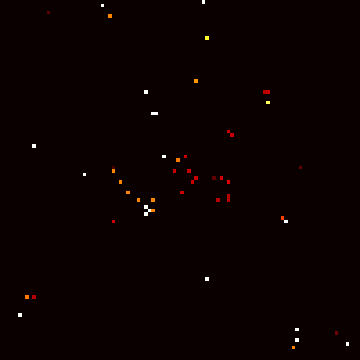
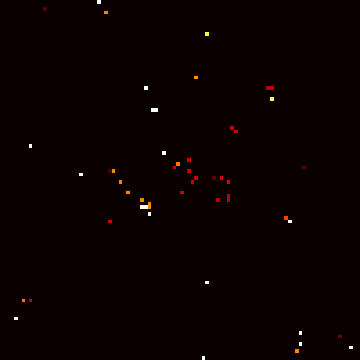
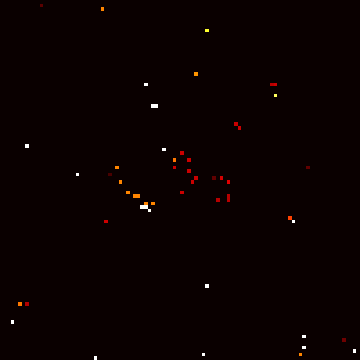
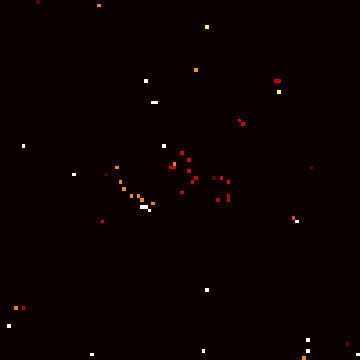
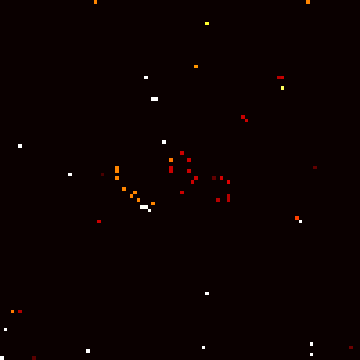
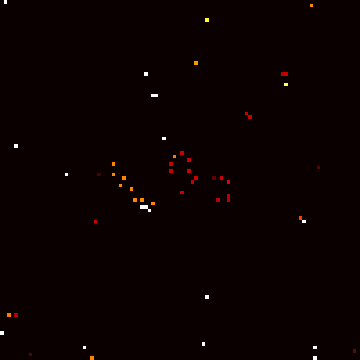
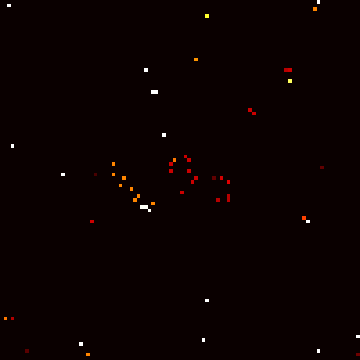
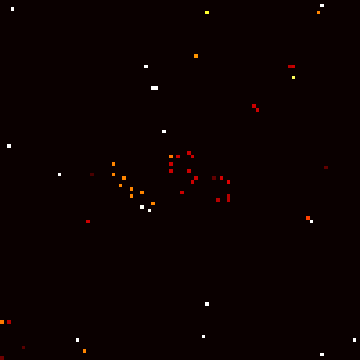
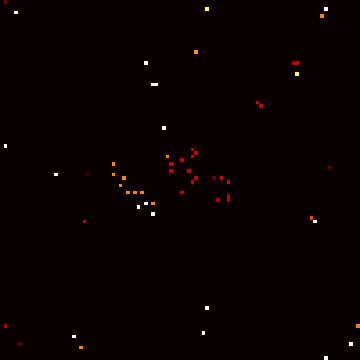
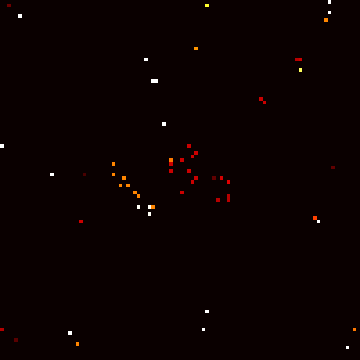
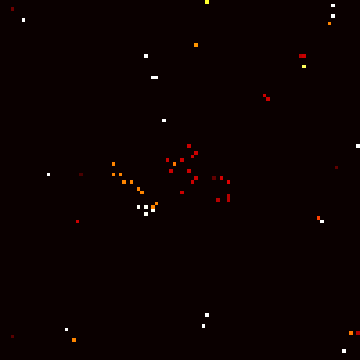
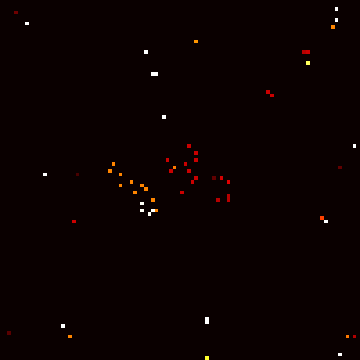
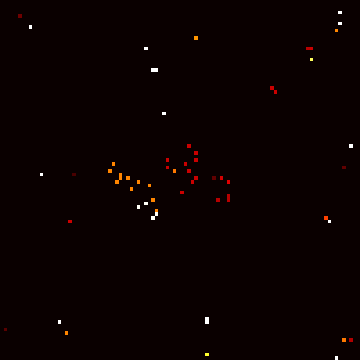
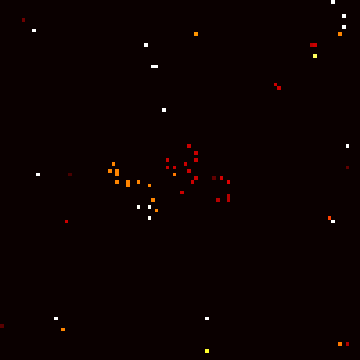
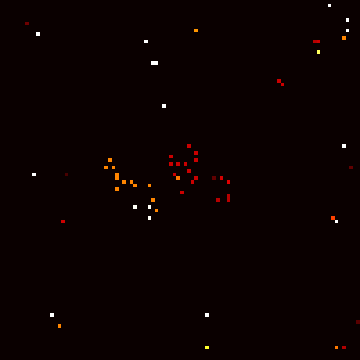
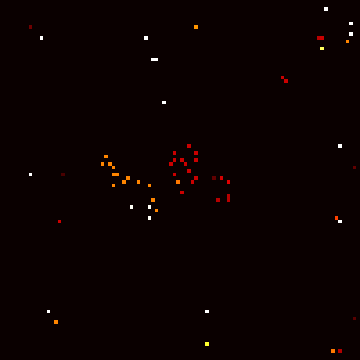
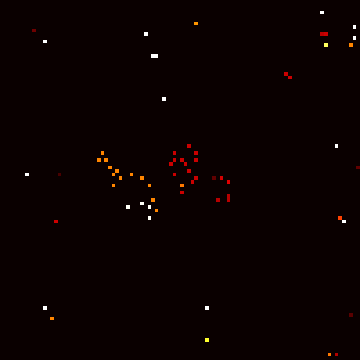
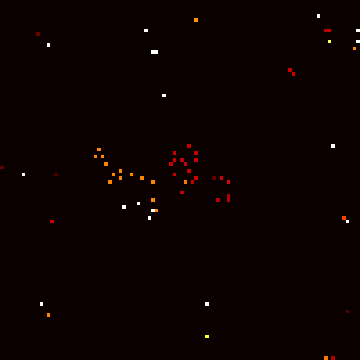
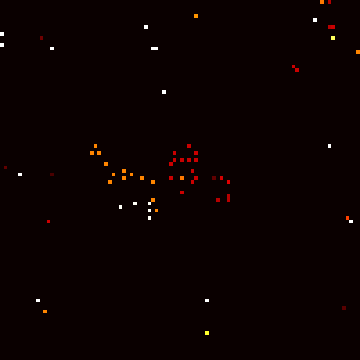
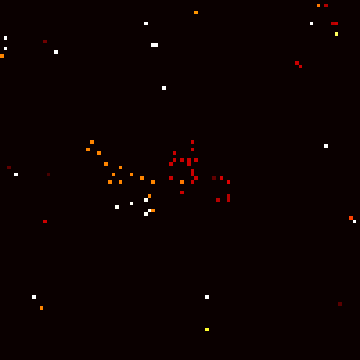
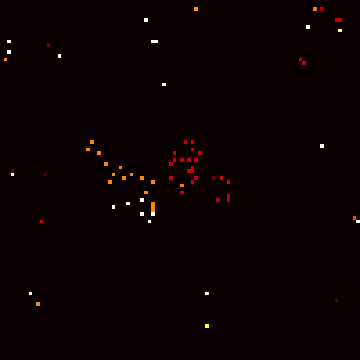
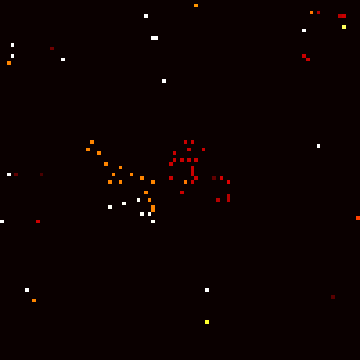
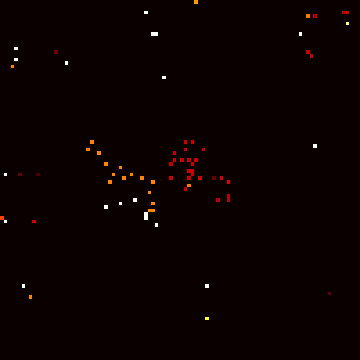
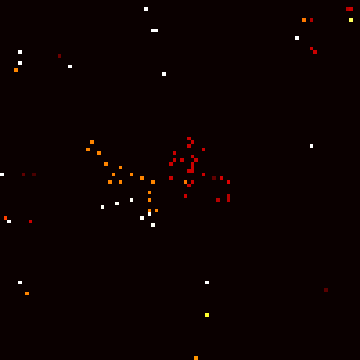
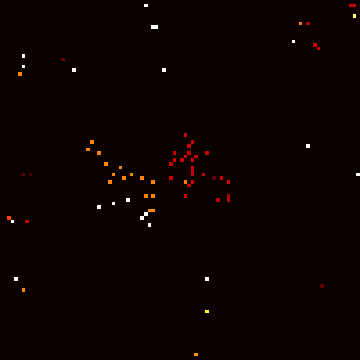
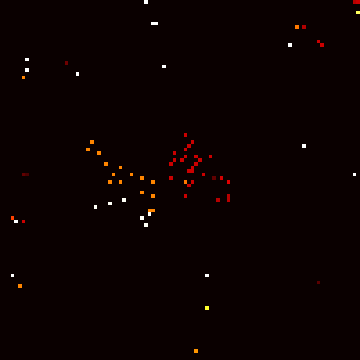
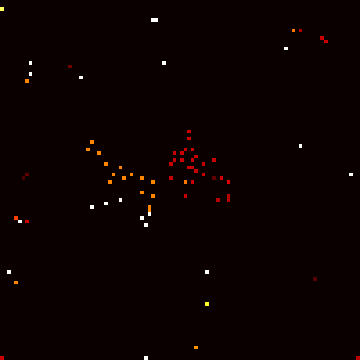
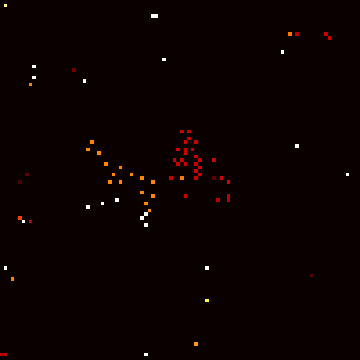
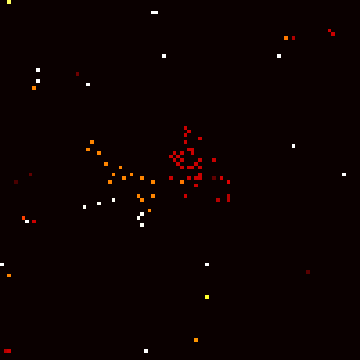
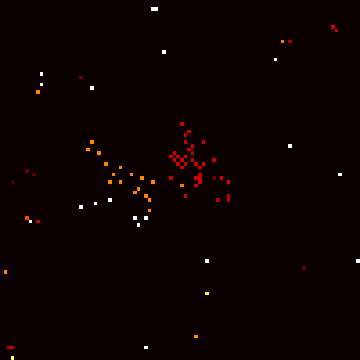
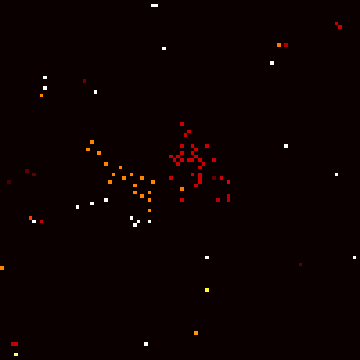
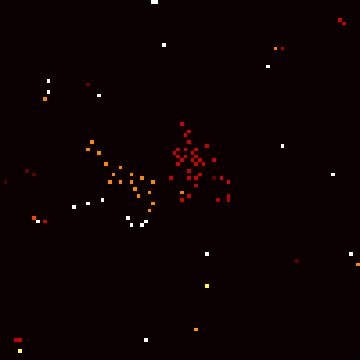
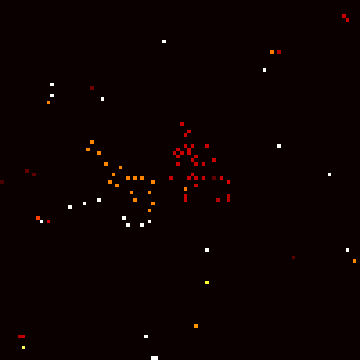
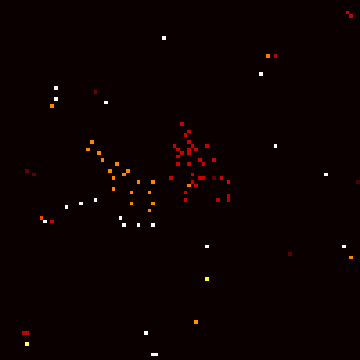
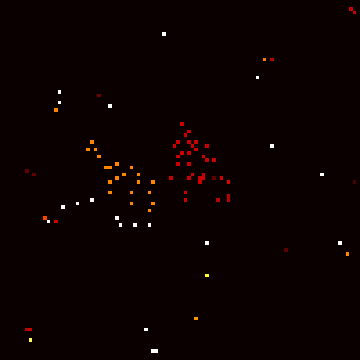
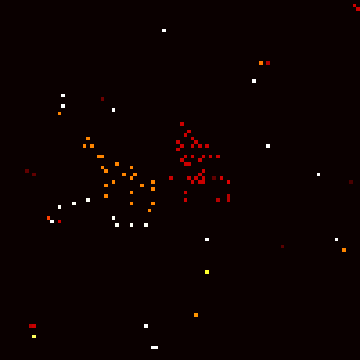
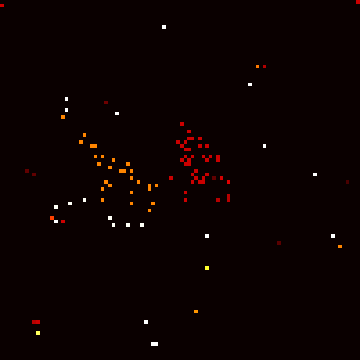
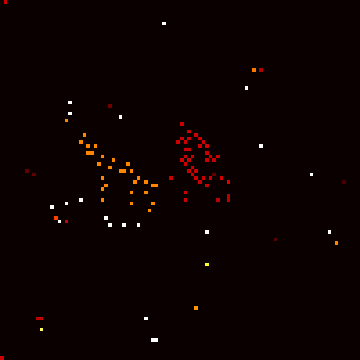
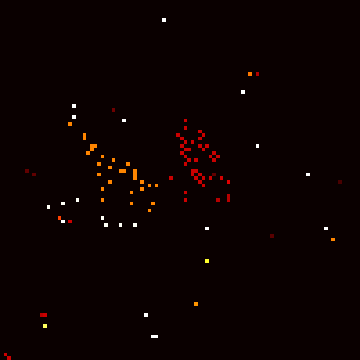
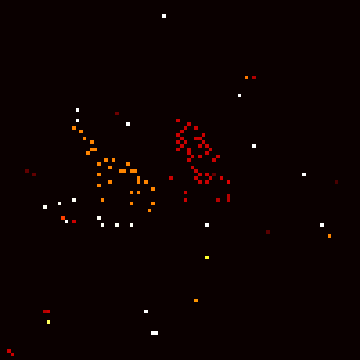
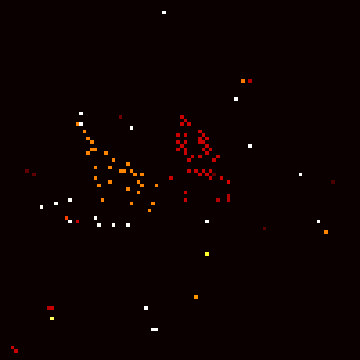
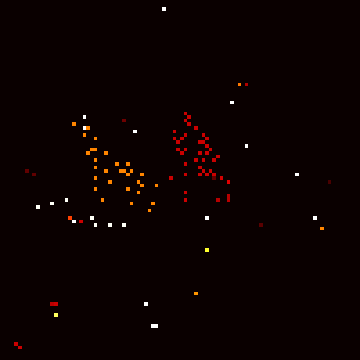
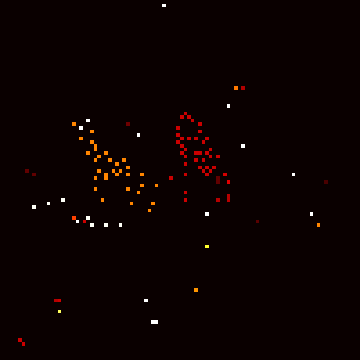
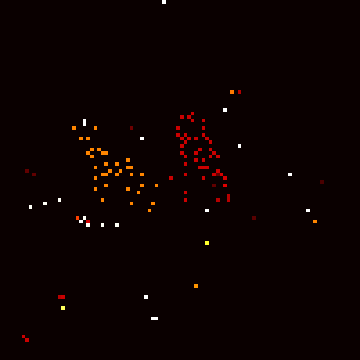
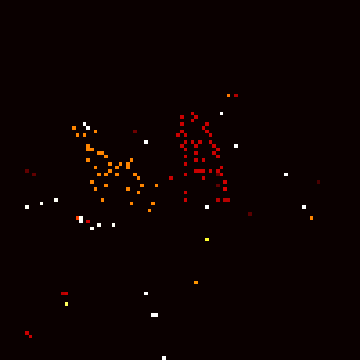
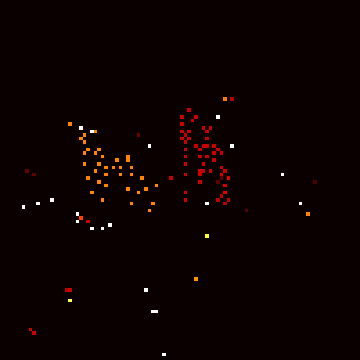
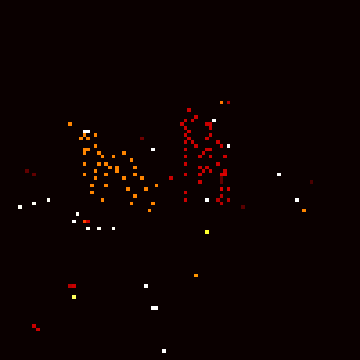
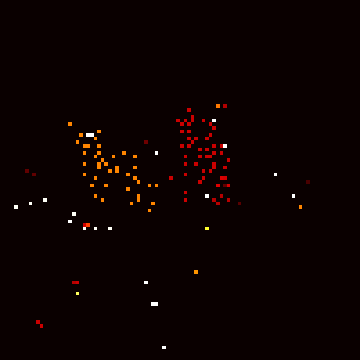
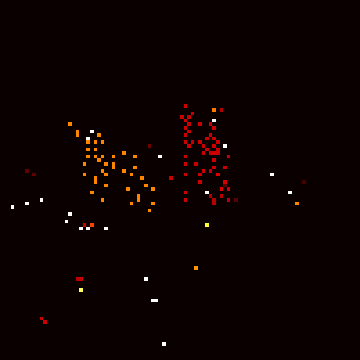
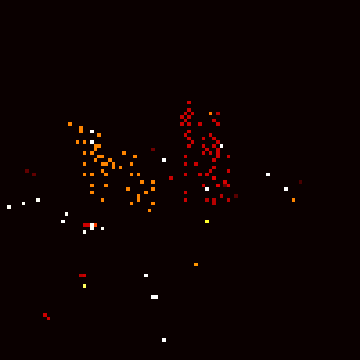
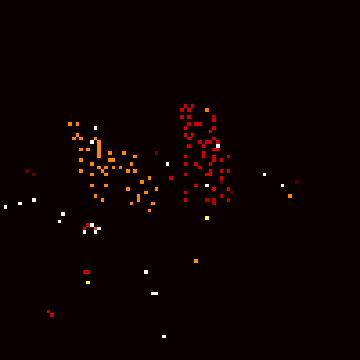
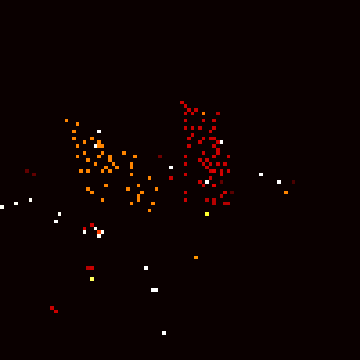
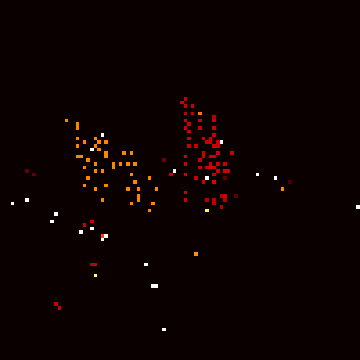
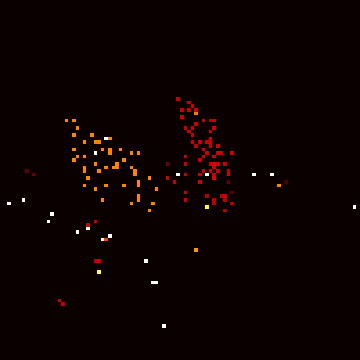
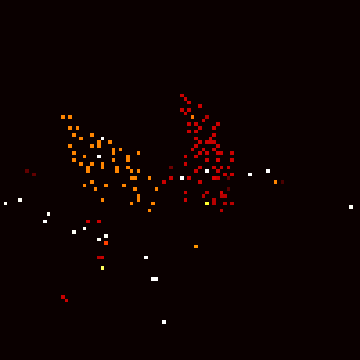
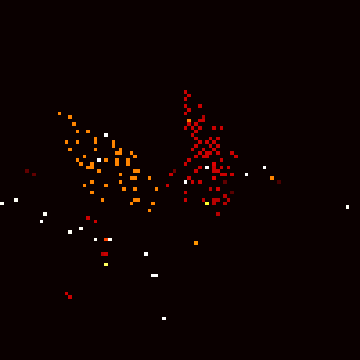
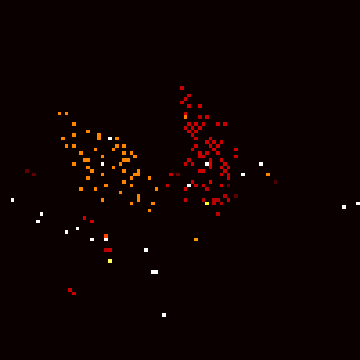
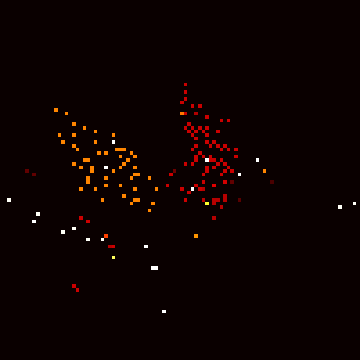
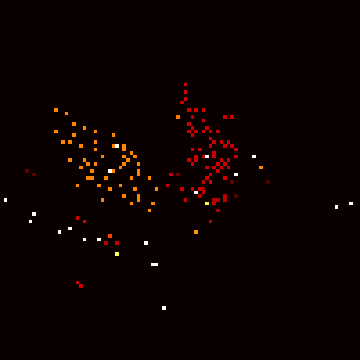
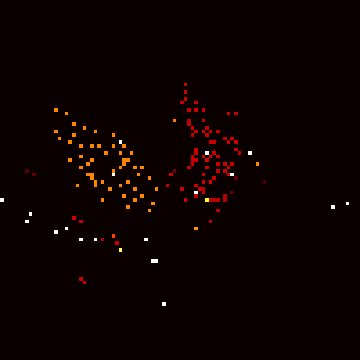
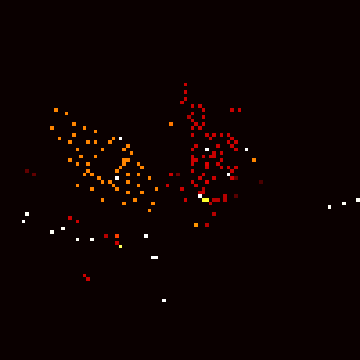
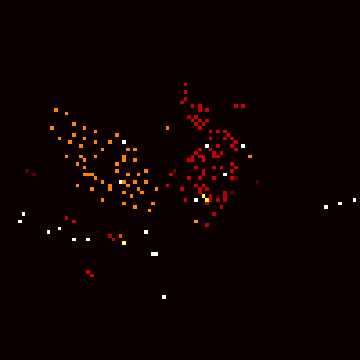
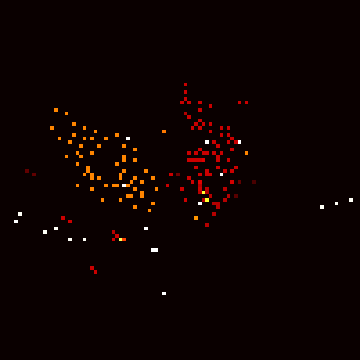
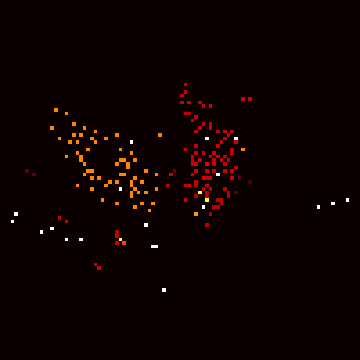
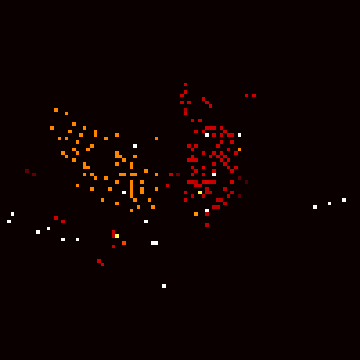
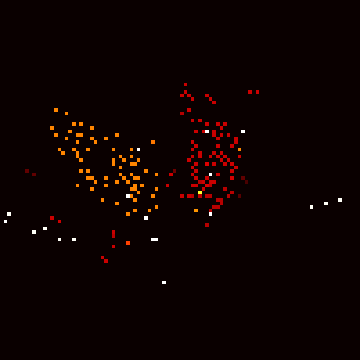
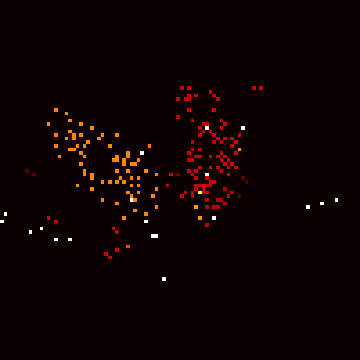
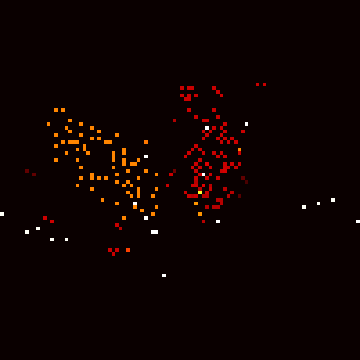
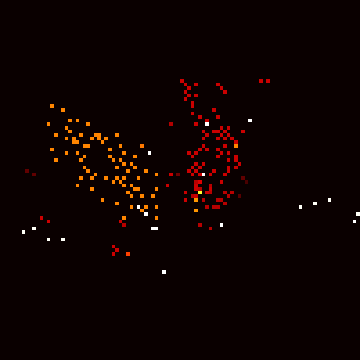
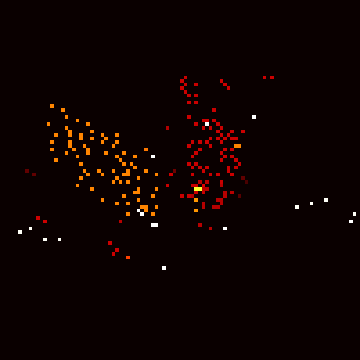
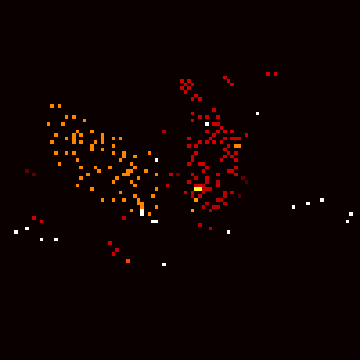
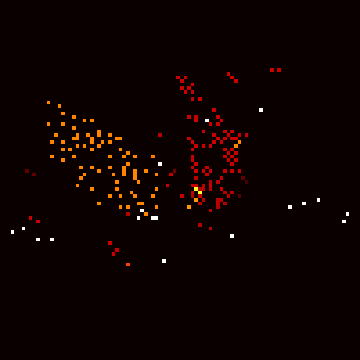
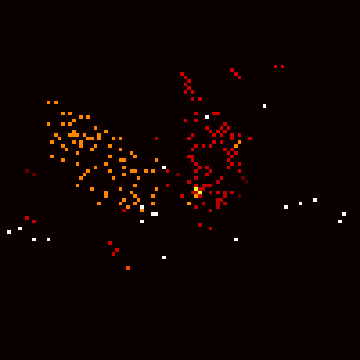
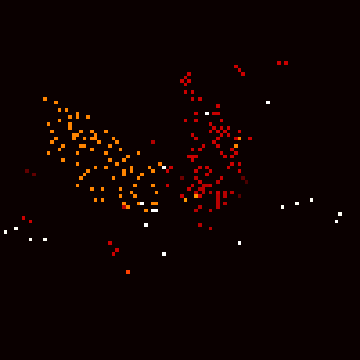
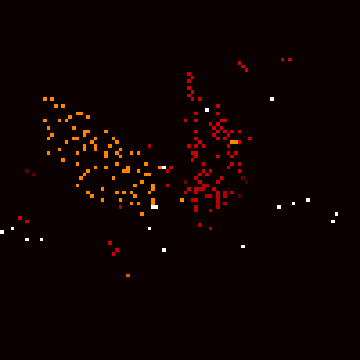
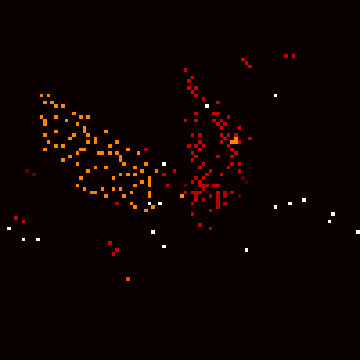
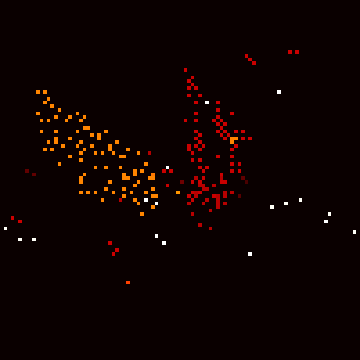
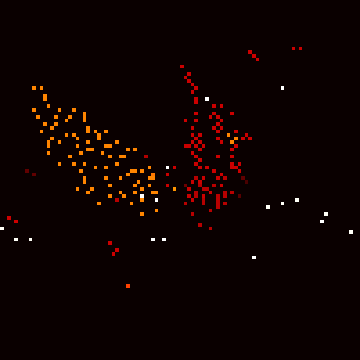
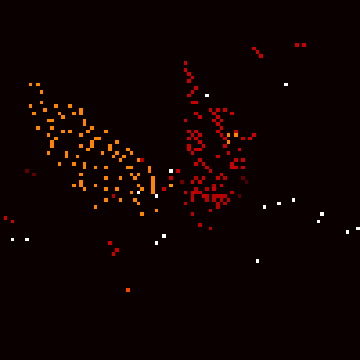
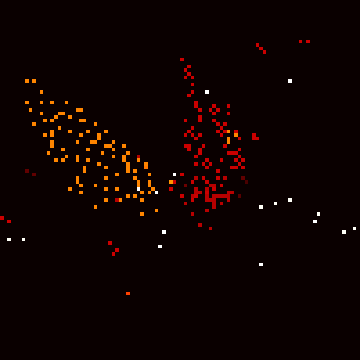
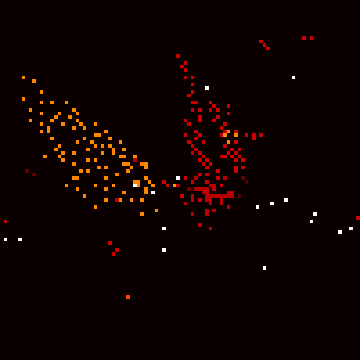
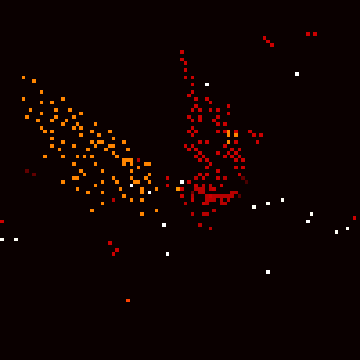
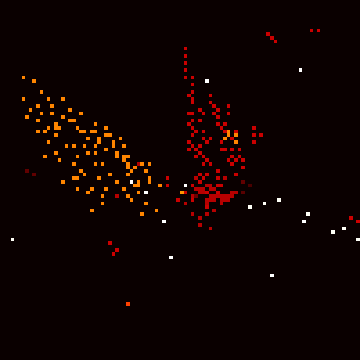
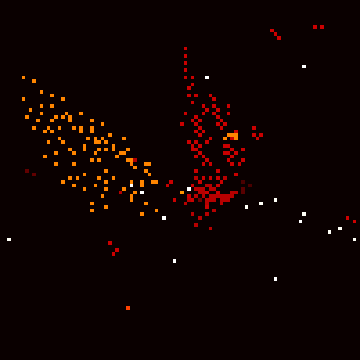
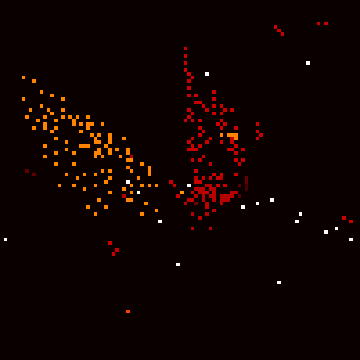
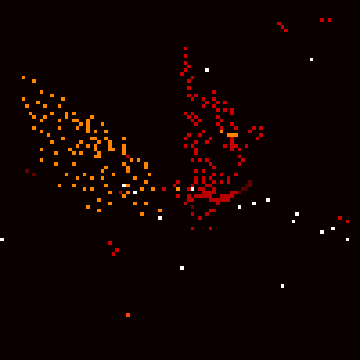
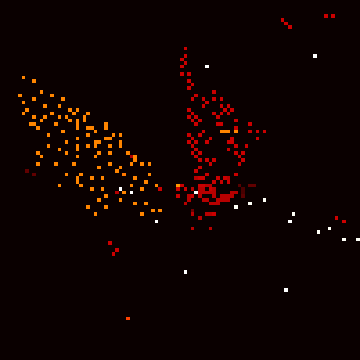
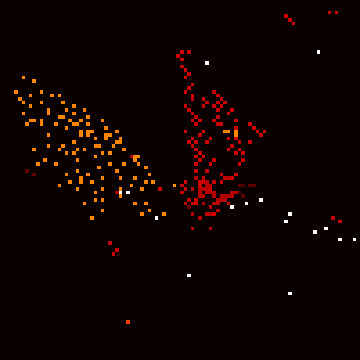
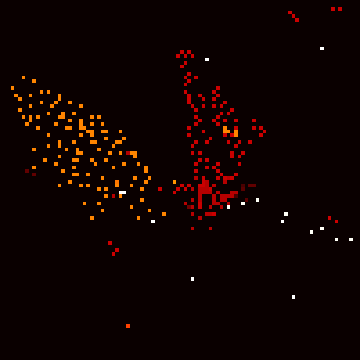
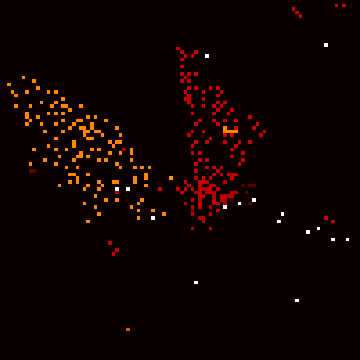
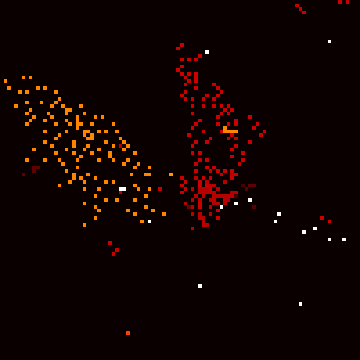
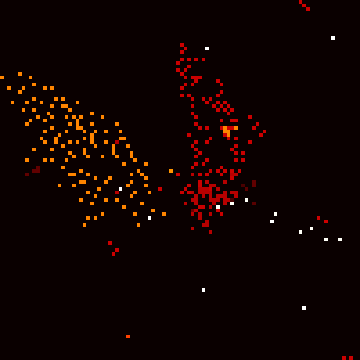
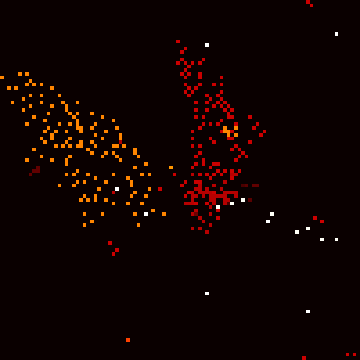
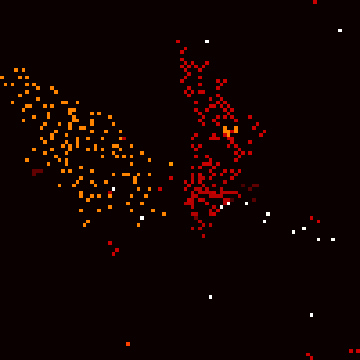
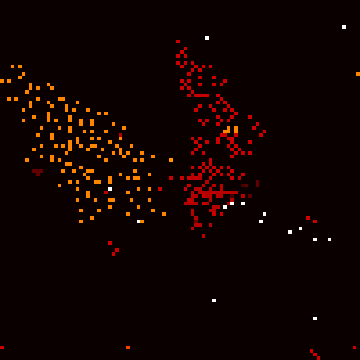
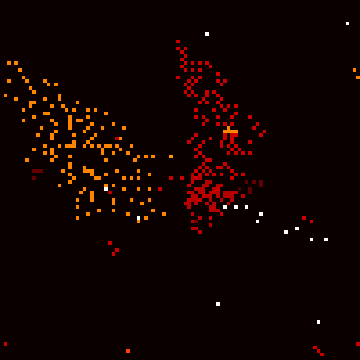
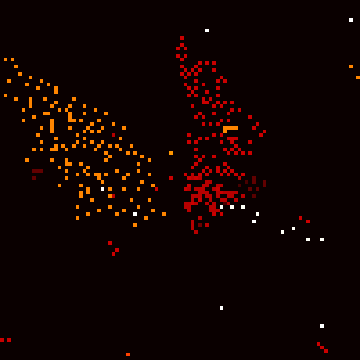
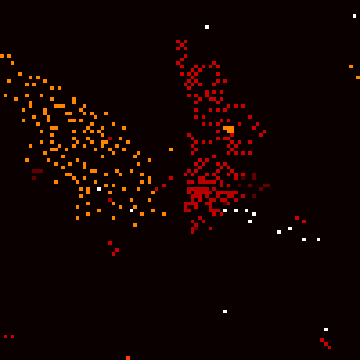
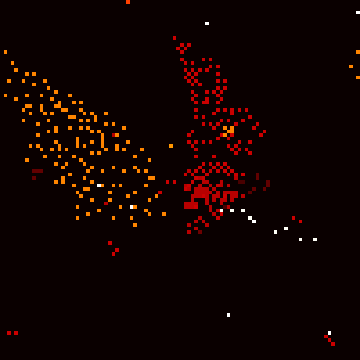
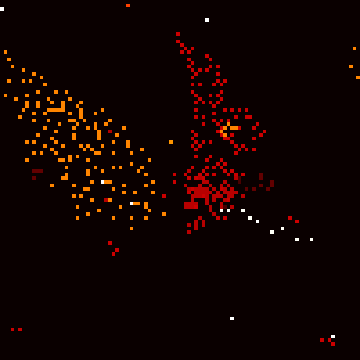
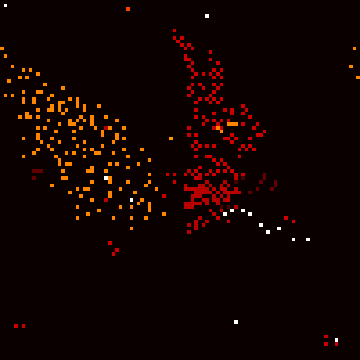
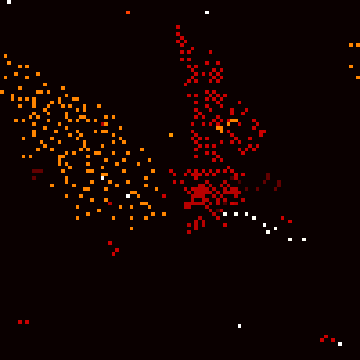
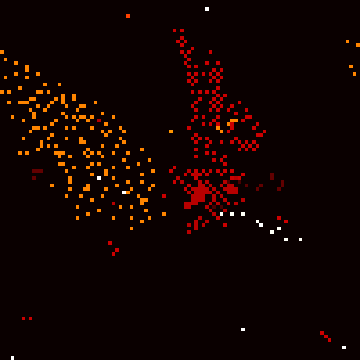
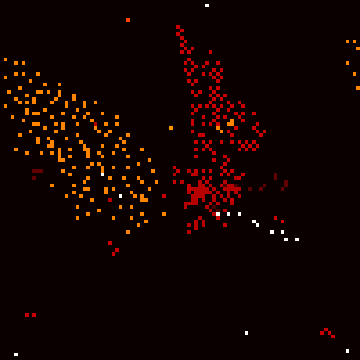
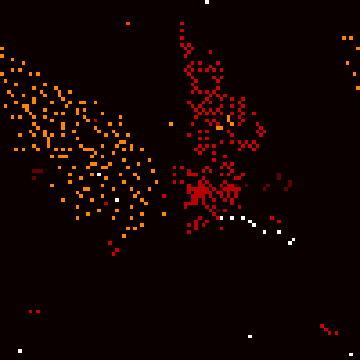
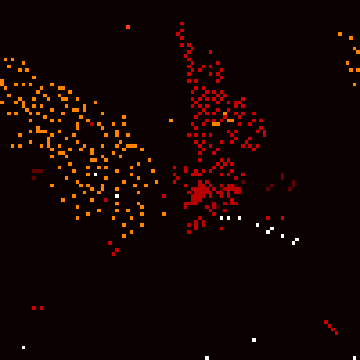
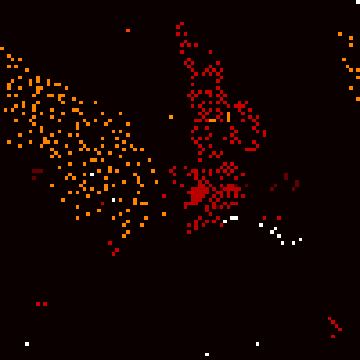
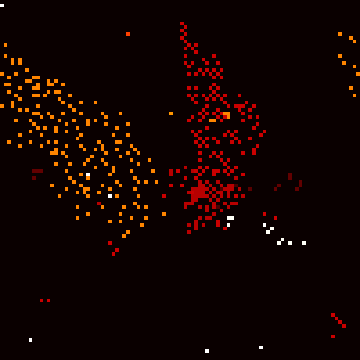
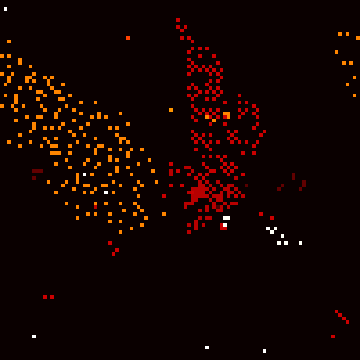
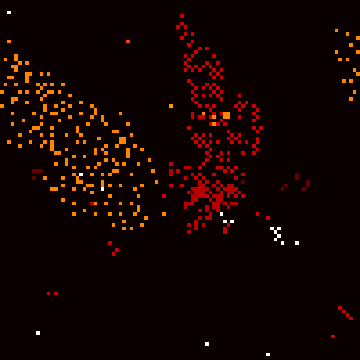
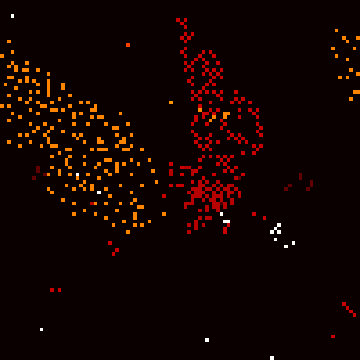
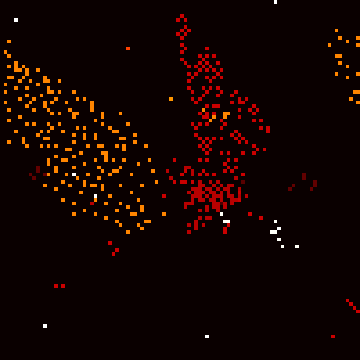
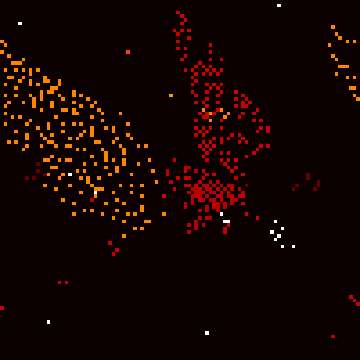
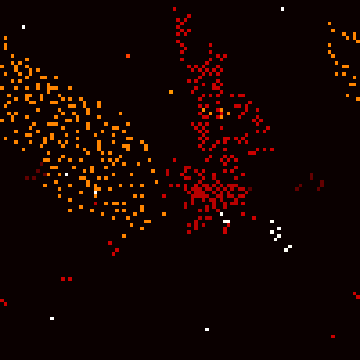
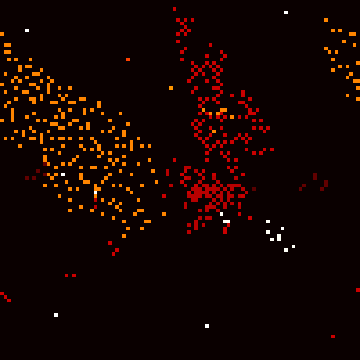
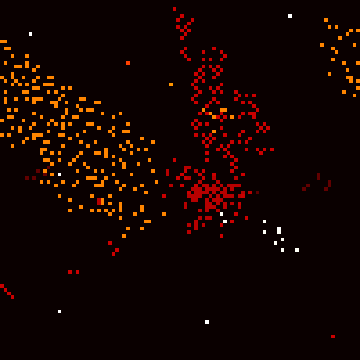
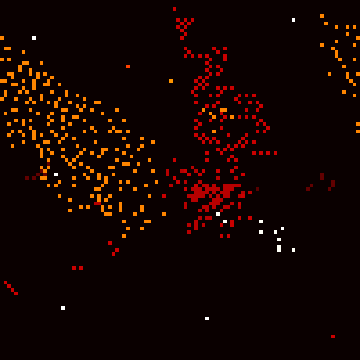
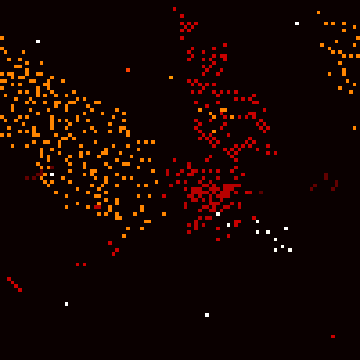
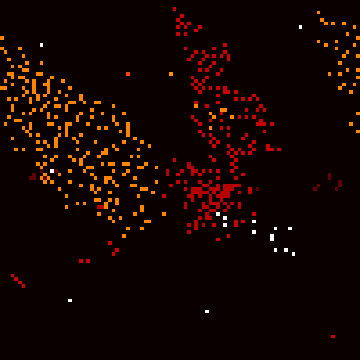
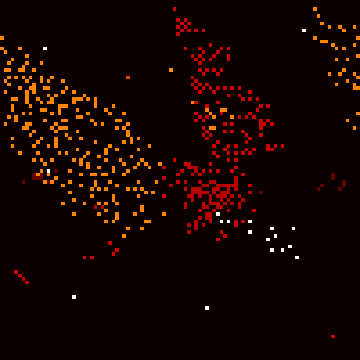
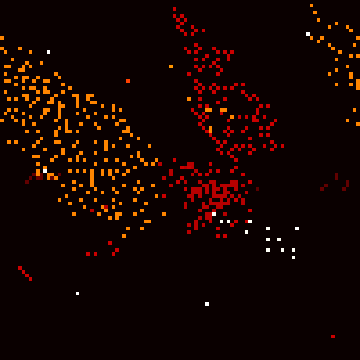
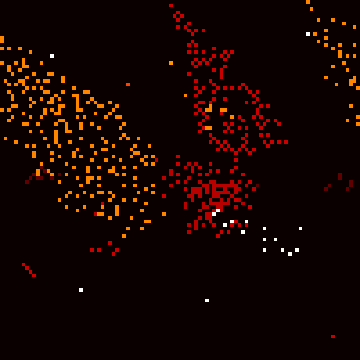
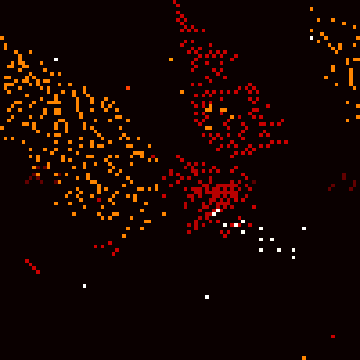
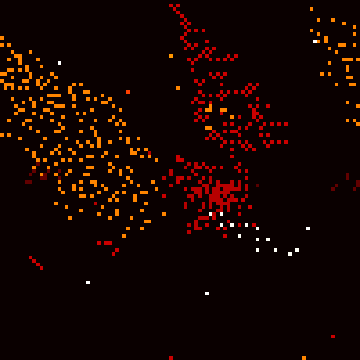
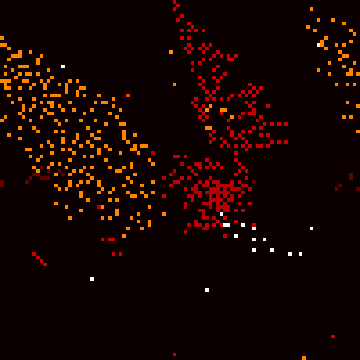
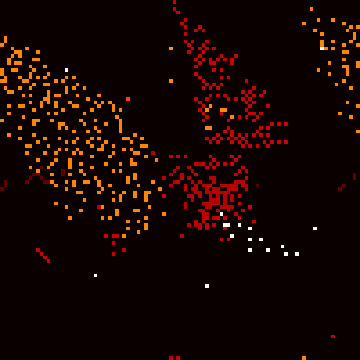
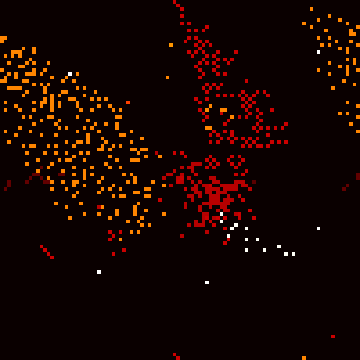
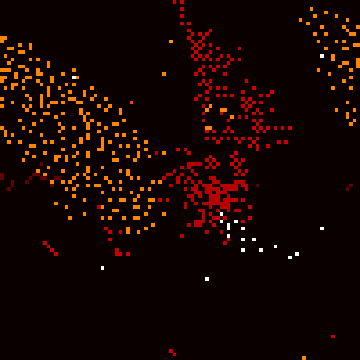
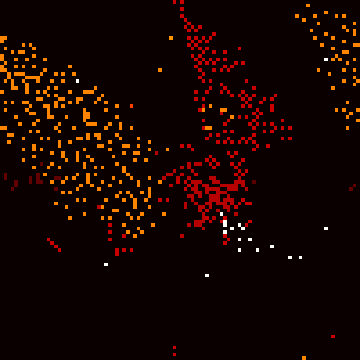
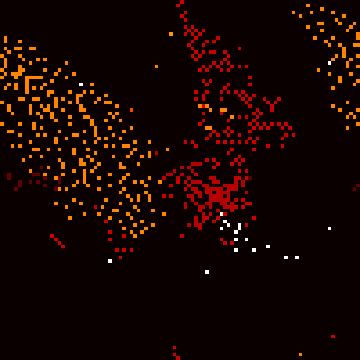
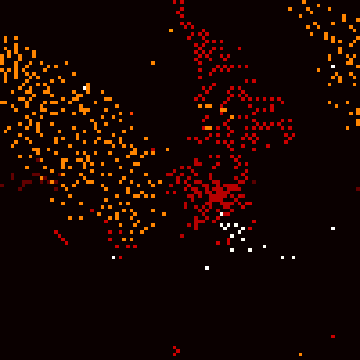
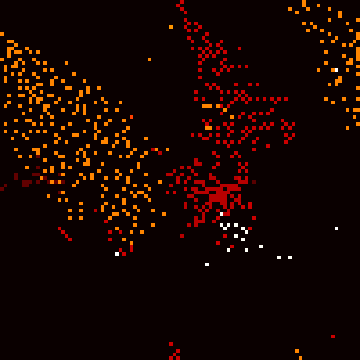
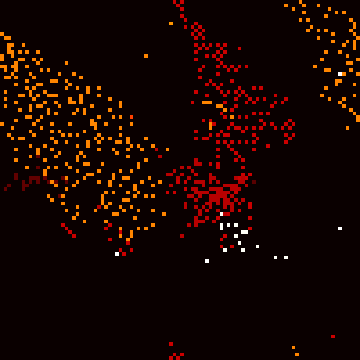
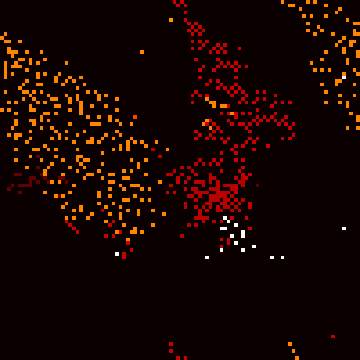
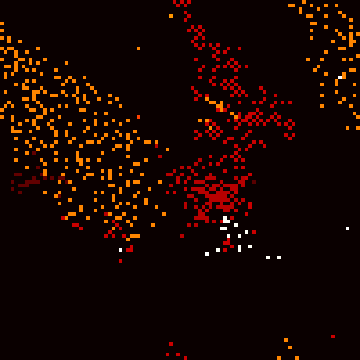
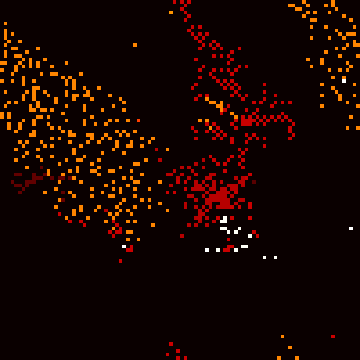
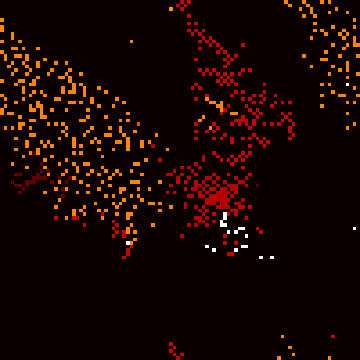
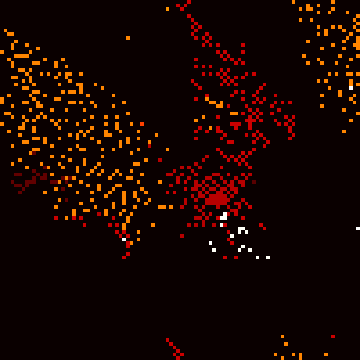
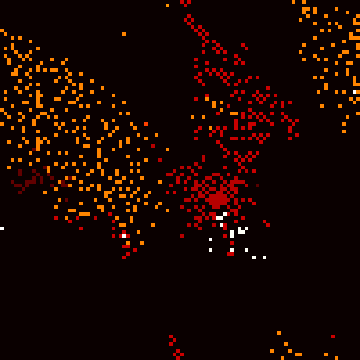
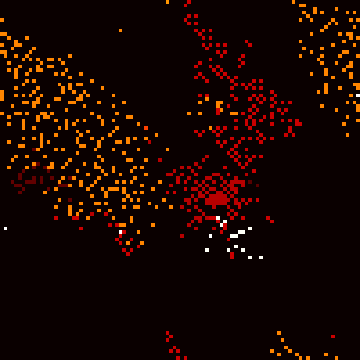
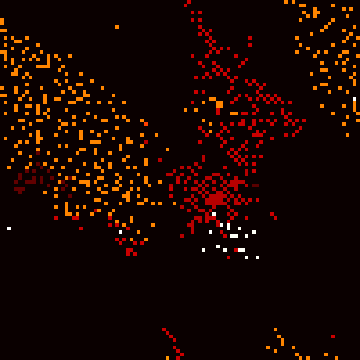
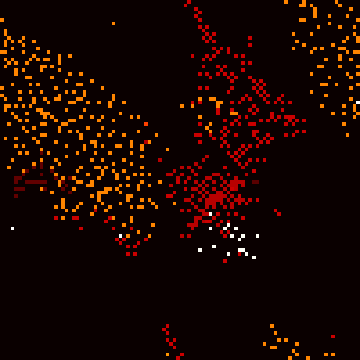
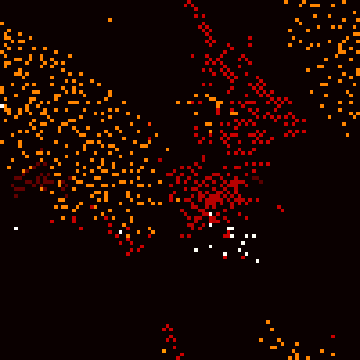
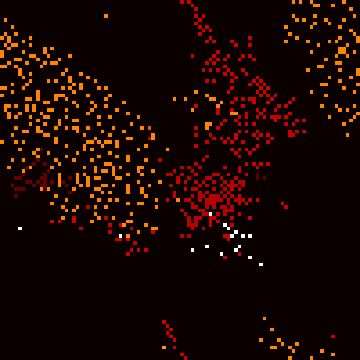
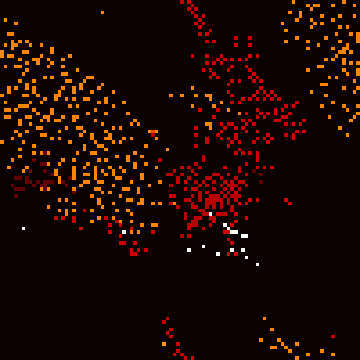
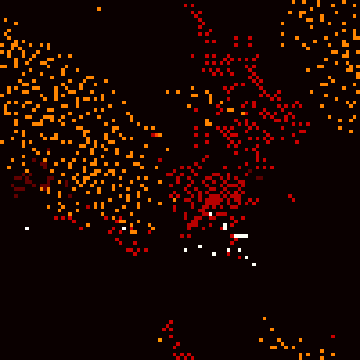
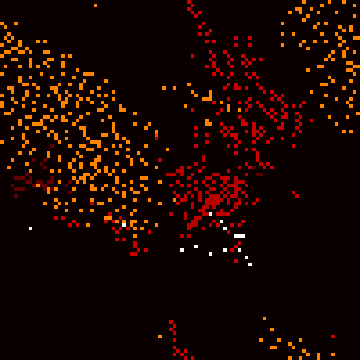
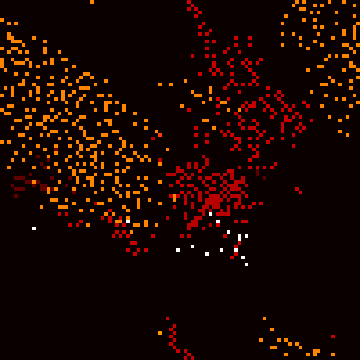
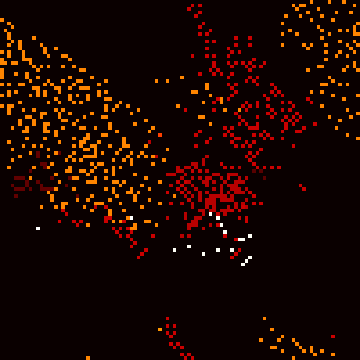
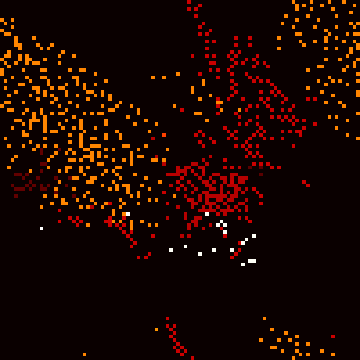
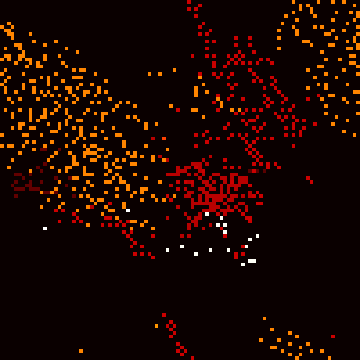
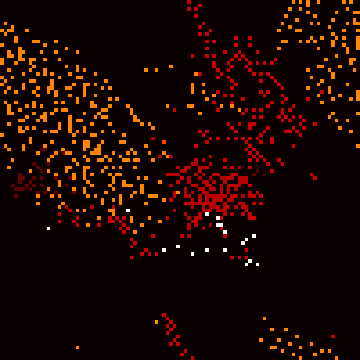
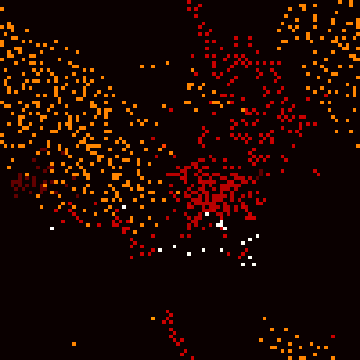
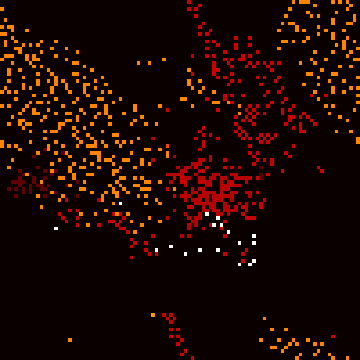
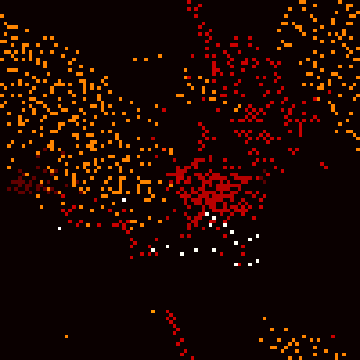
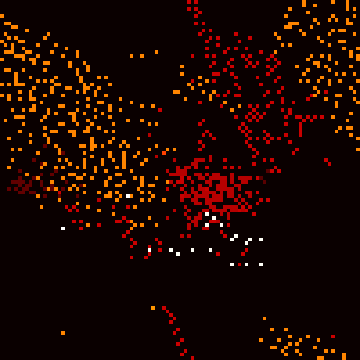
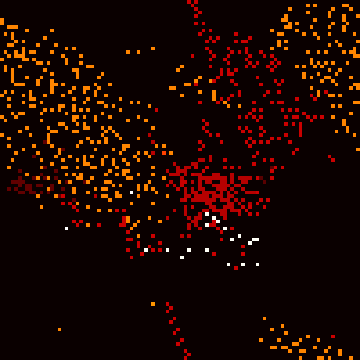
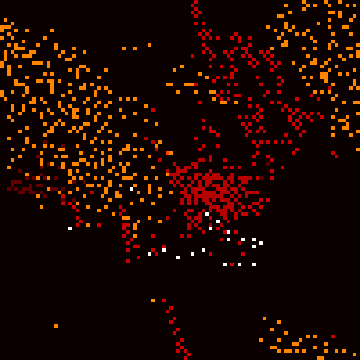

In [5]:
gr, c = slime();gr


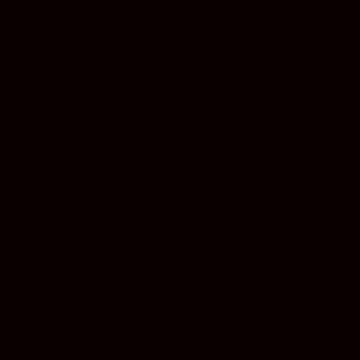
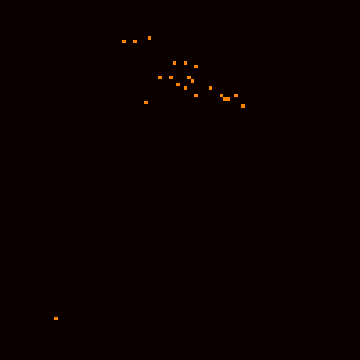
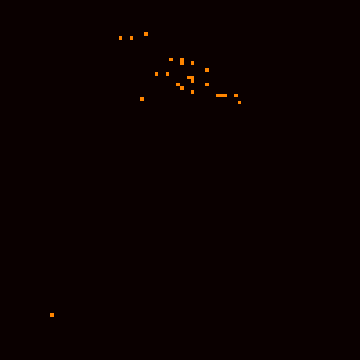
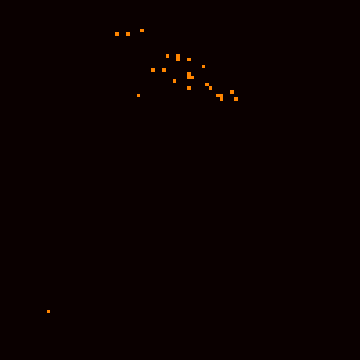
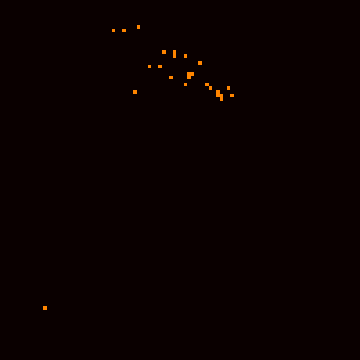
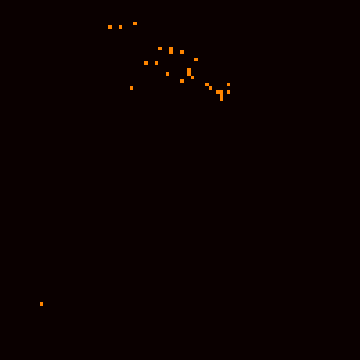
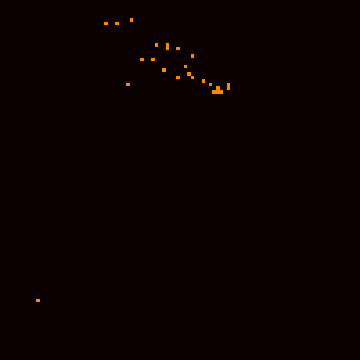
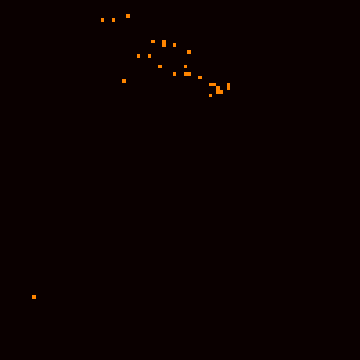
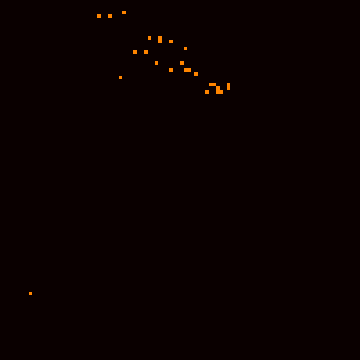
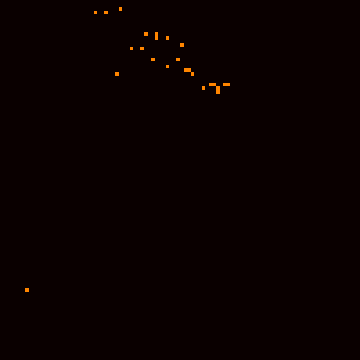
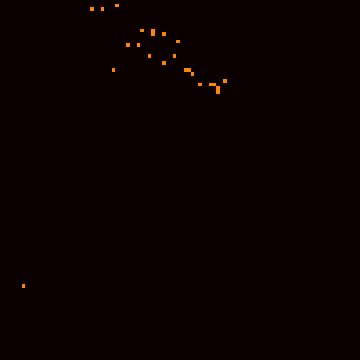
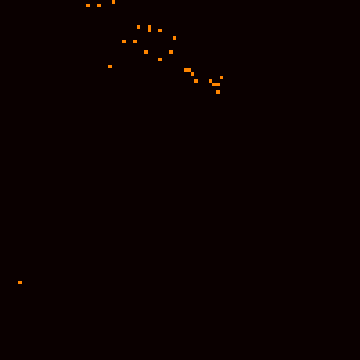
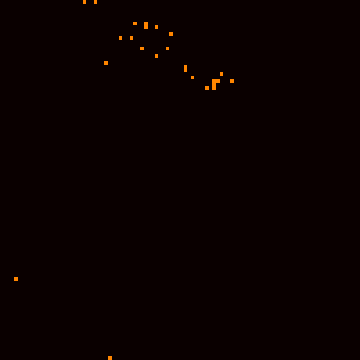
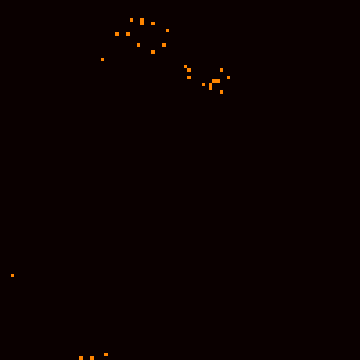
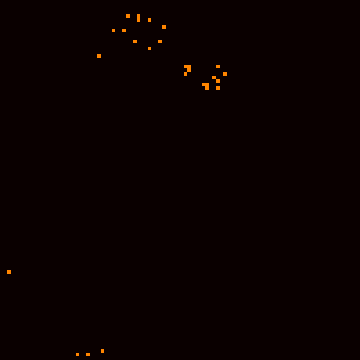
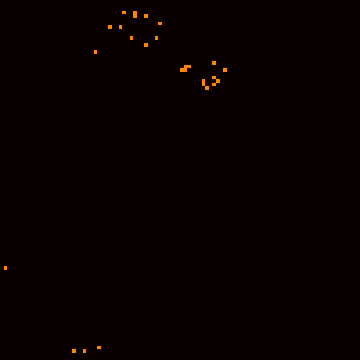
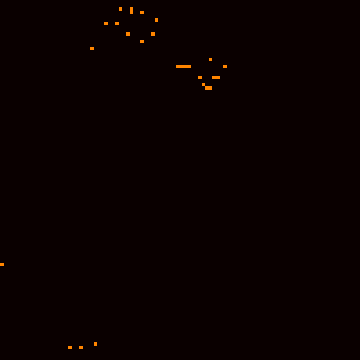
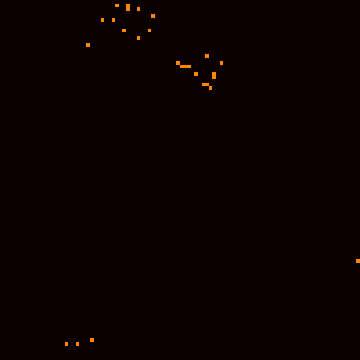
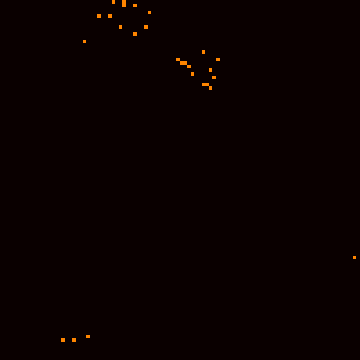
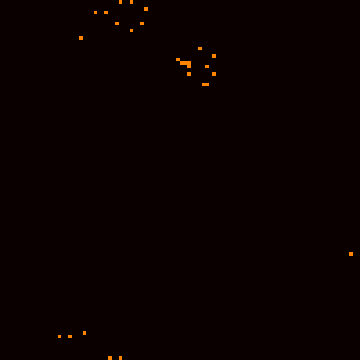
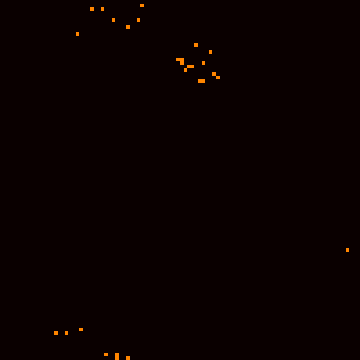
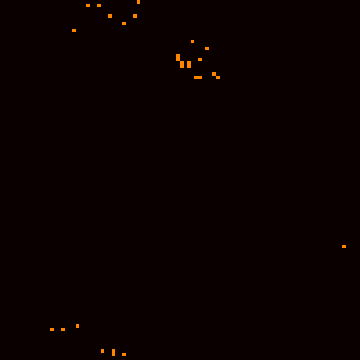
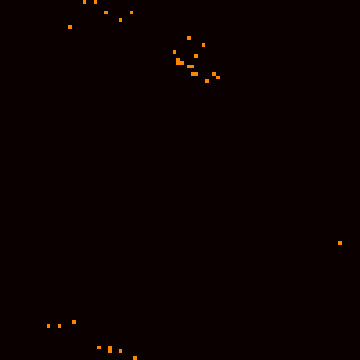
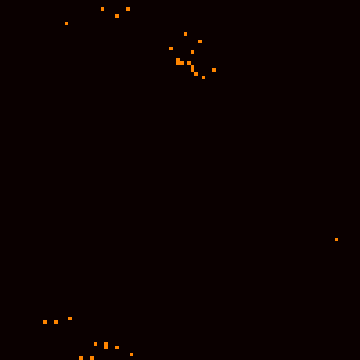
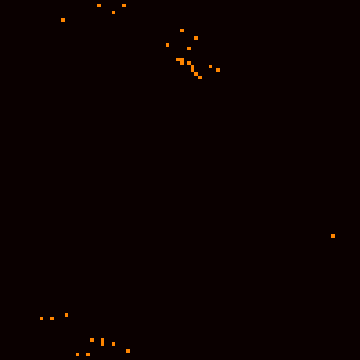
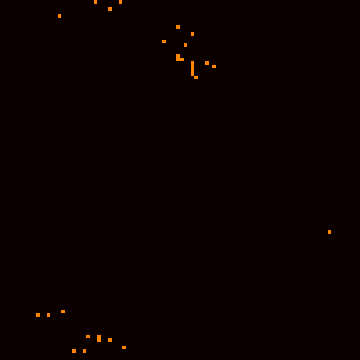
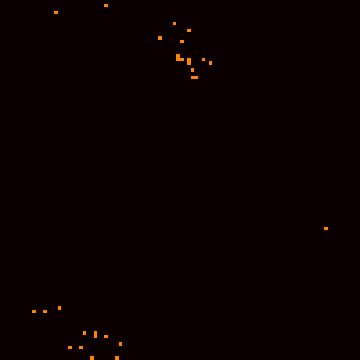
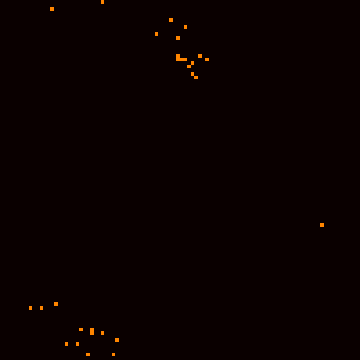
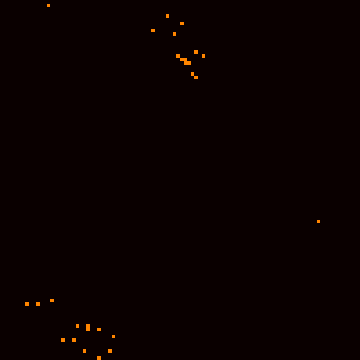
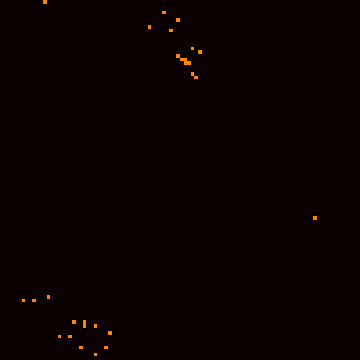
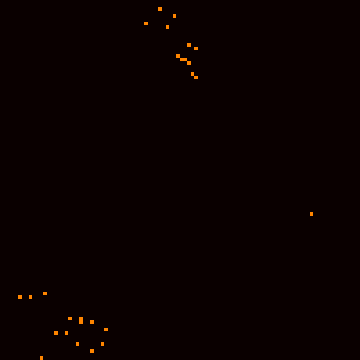
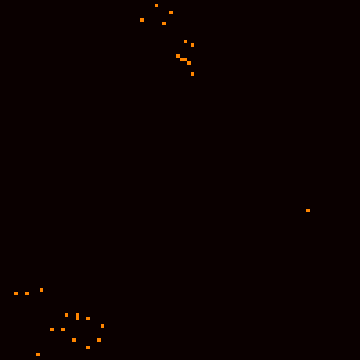
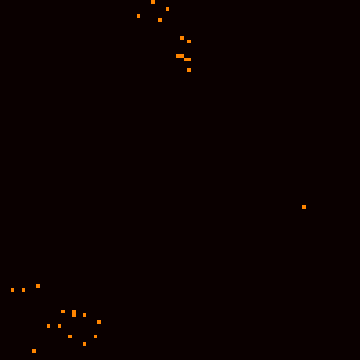
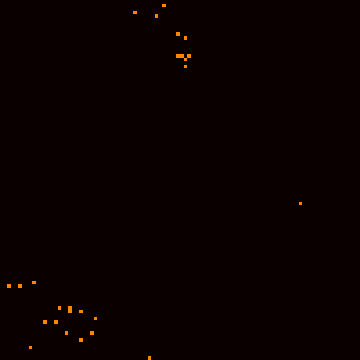
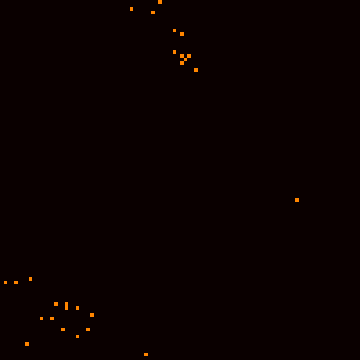
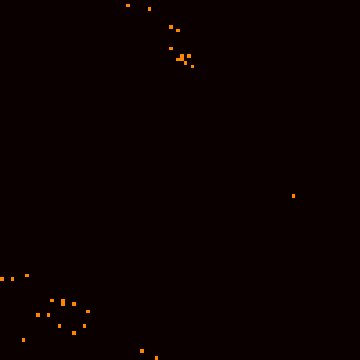
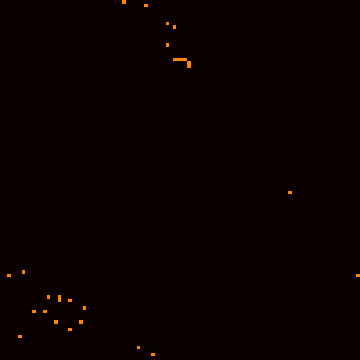
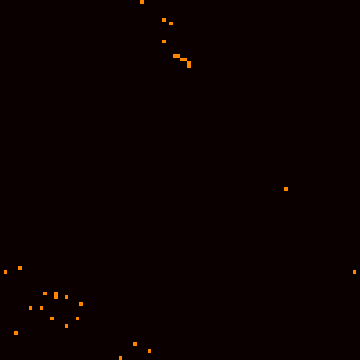
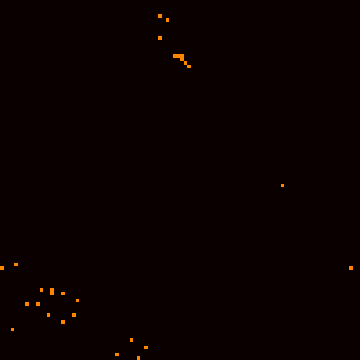
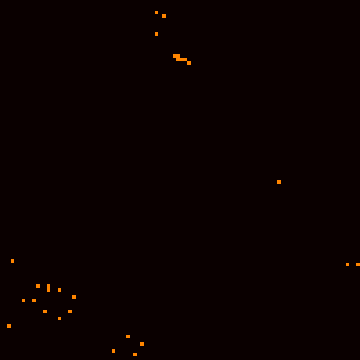
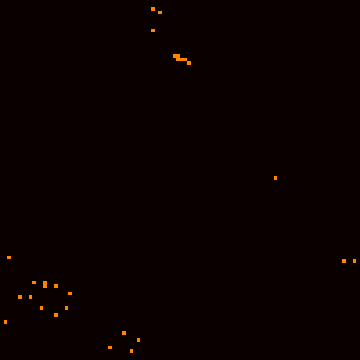
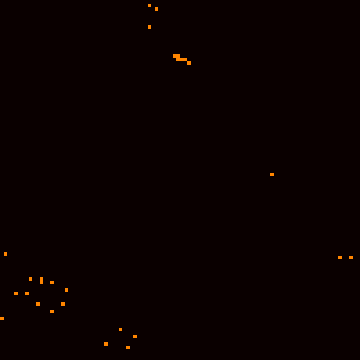
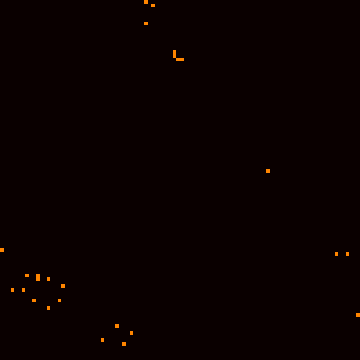
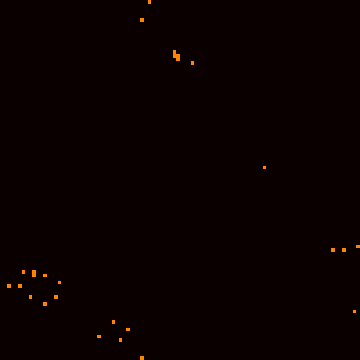
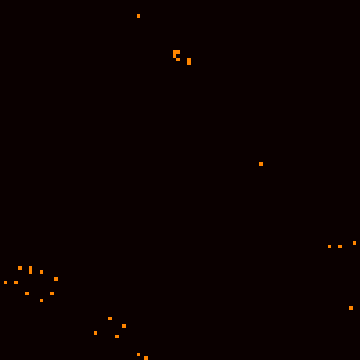
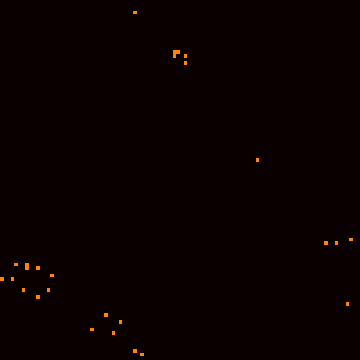
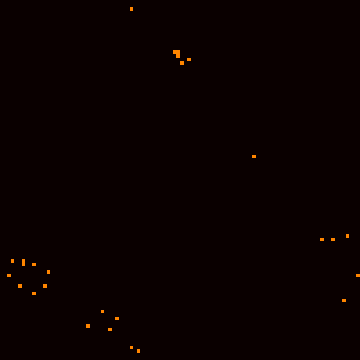
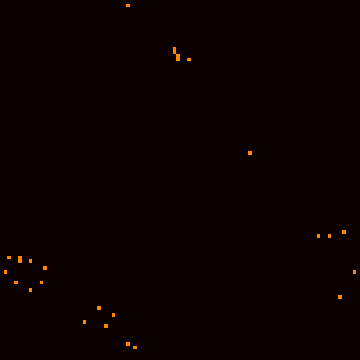
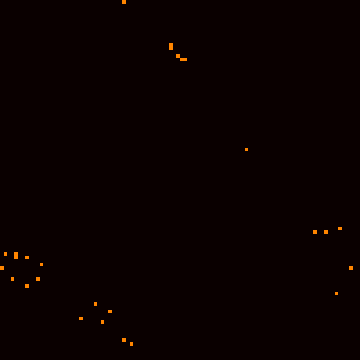
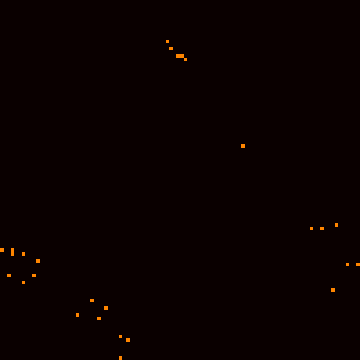
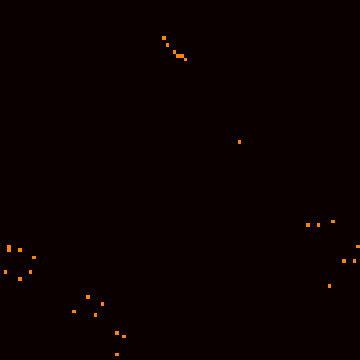
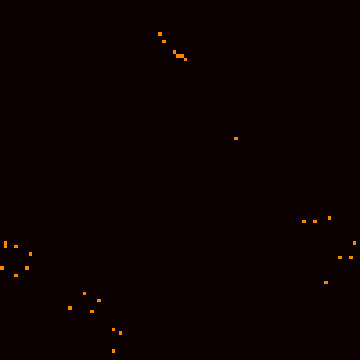
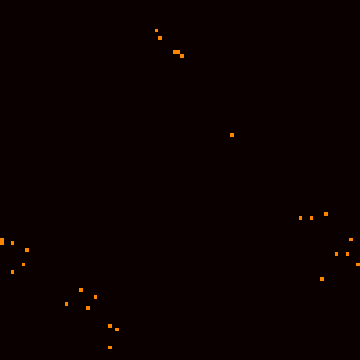
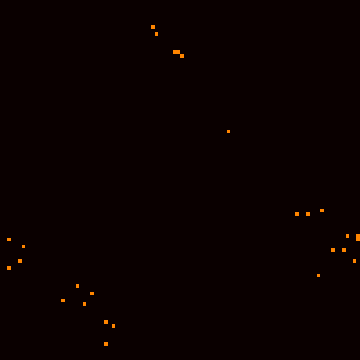
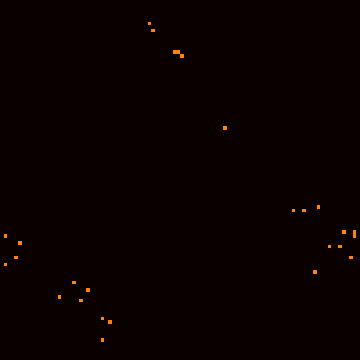
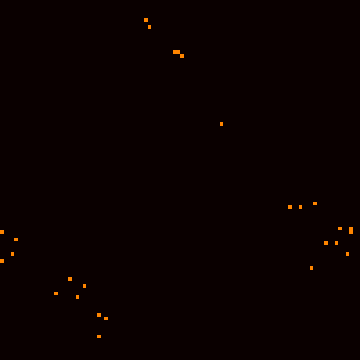
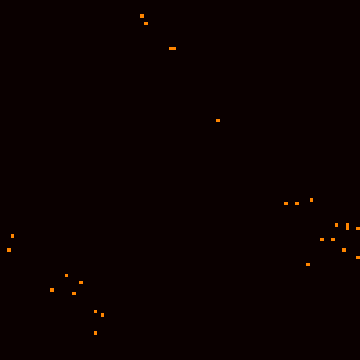
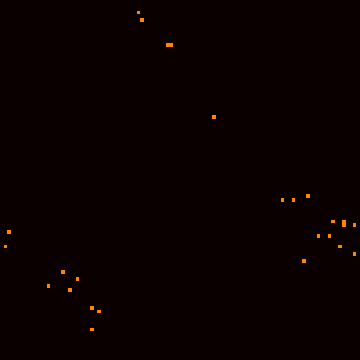
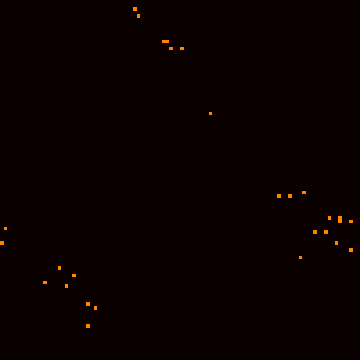
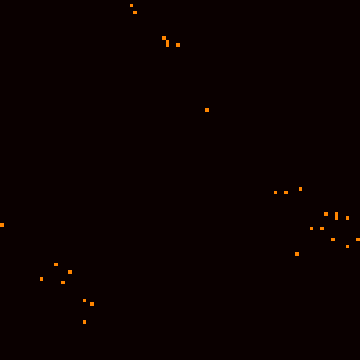
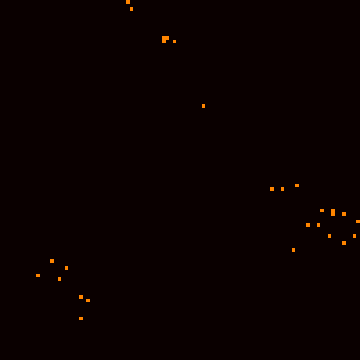
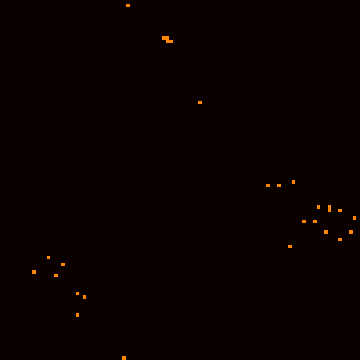
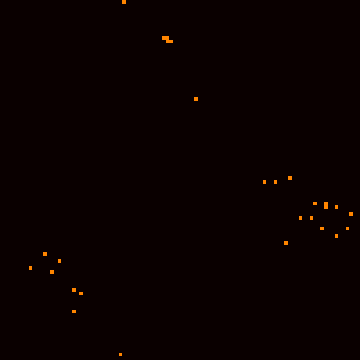
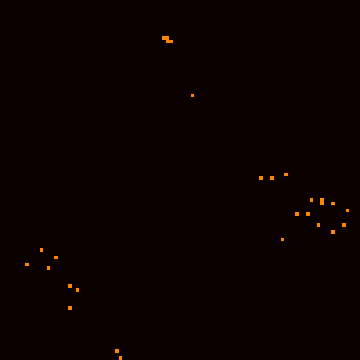
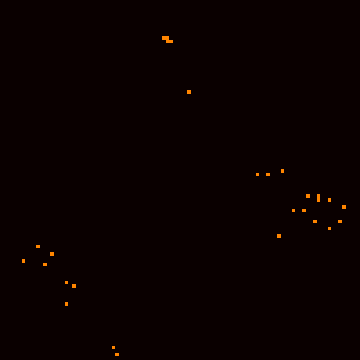
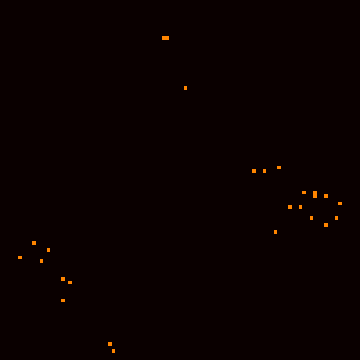
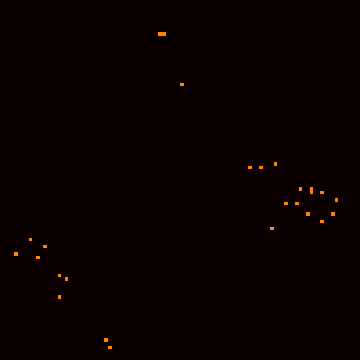
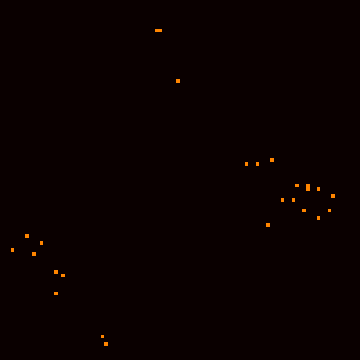
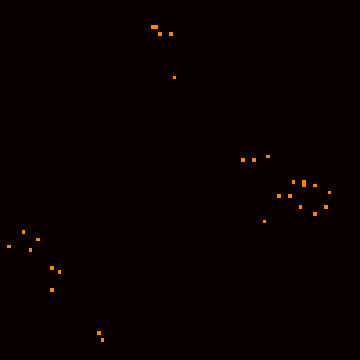
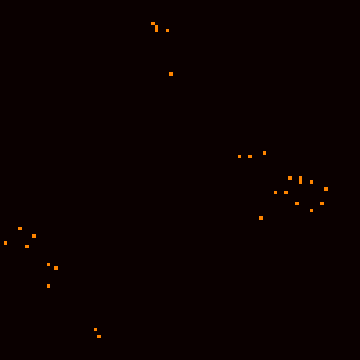
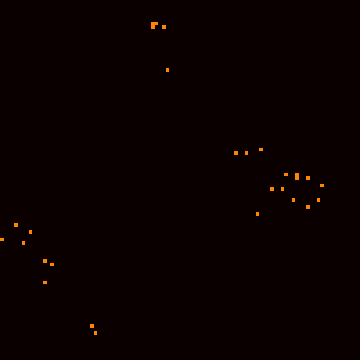
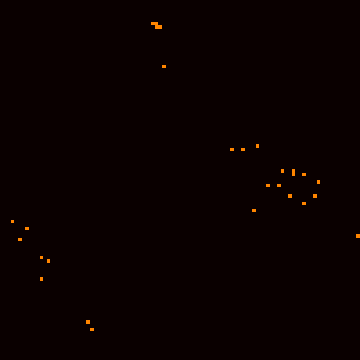
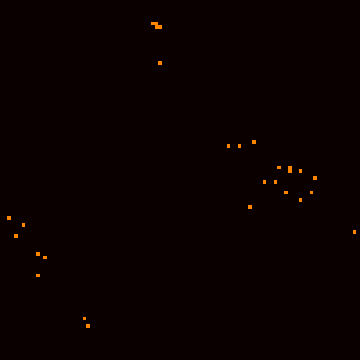
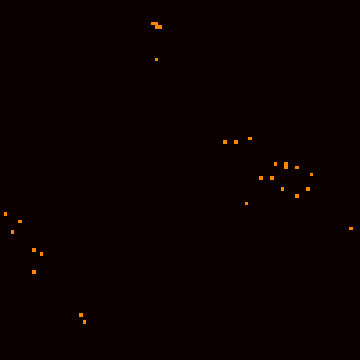
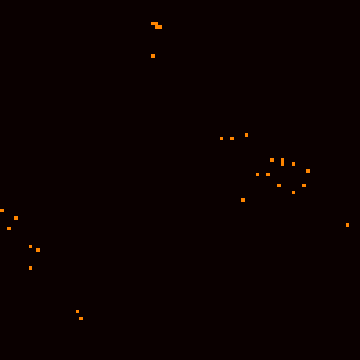
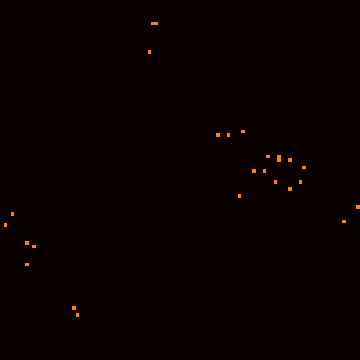
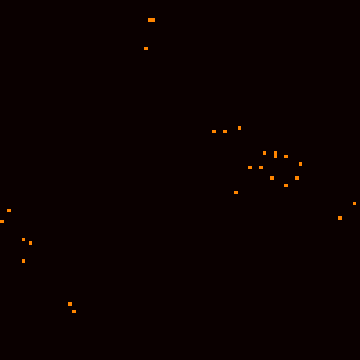
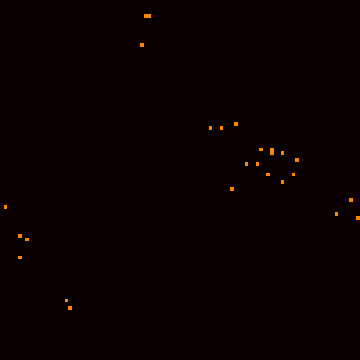
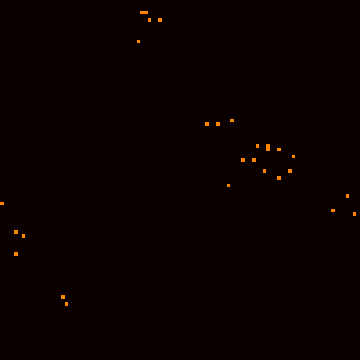
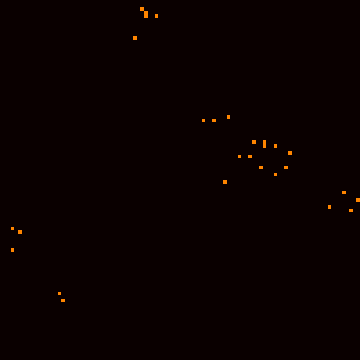
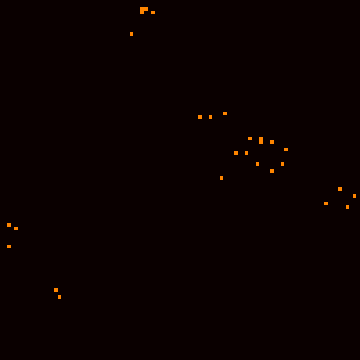
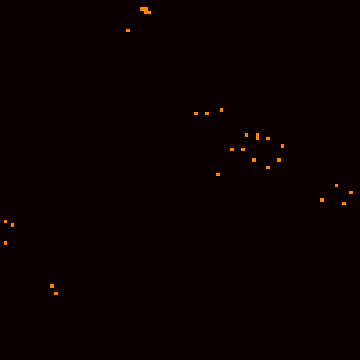
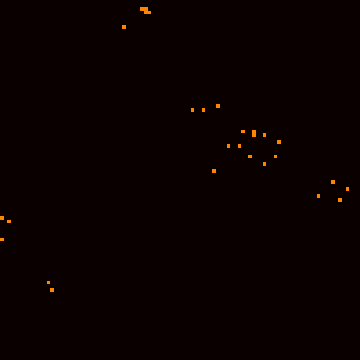
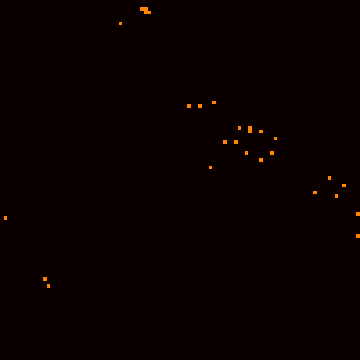
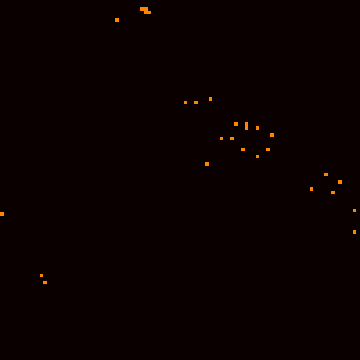
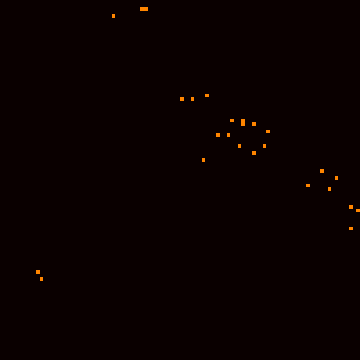
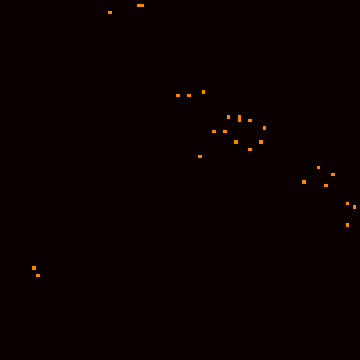
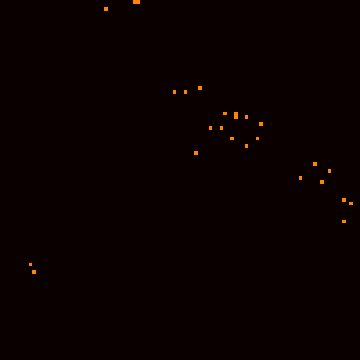
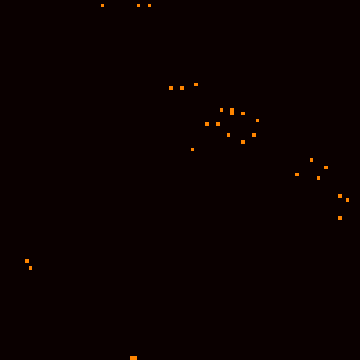
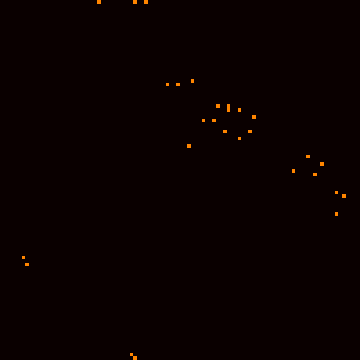
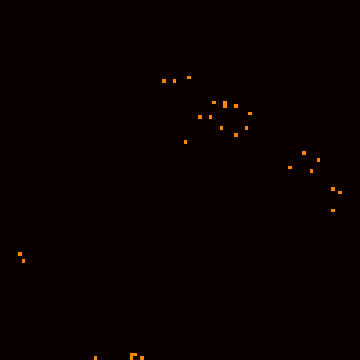
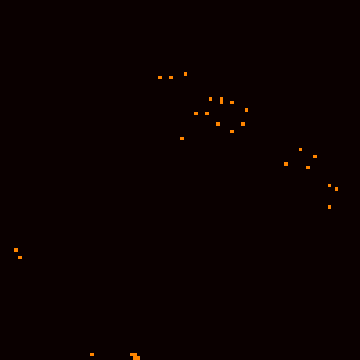
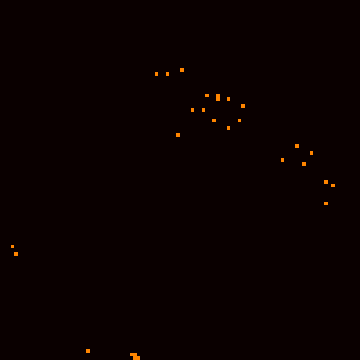
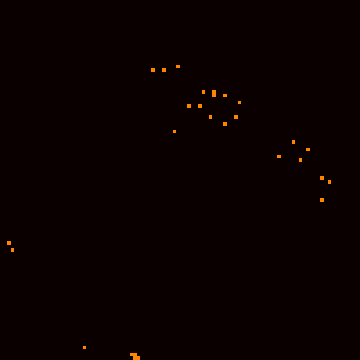
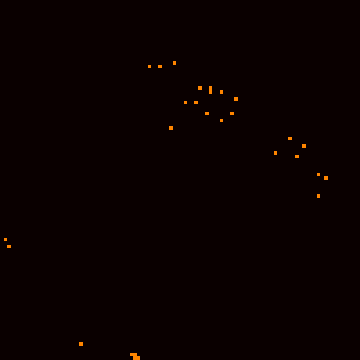
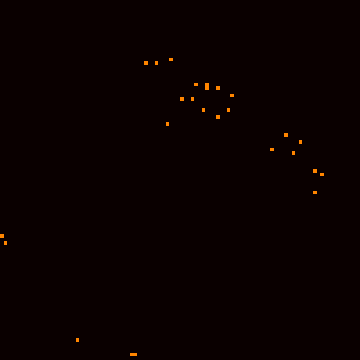
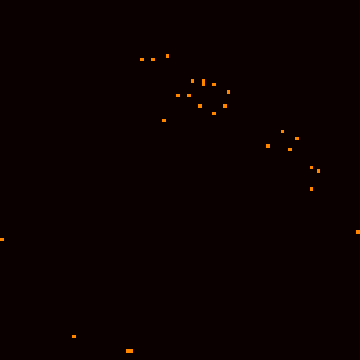
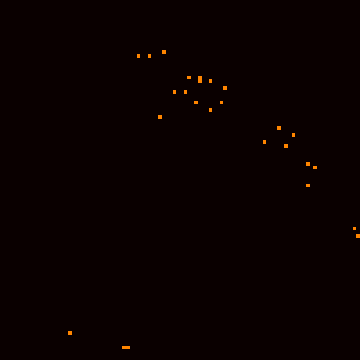
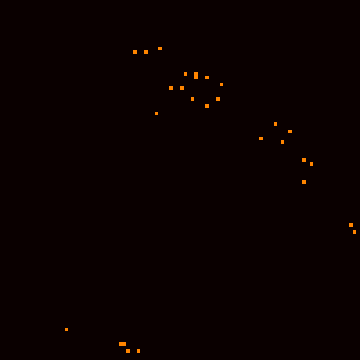
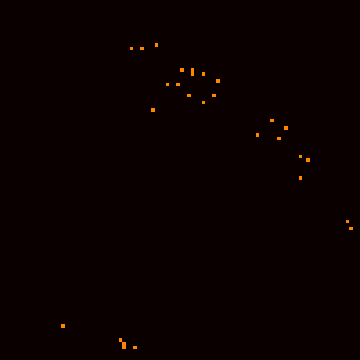
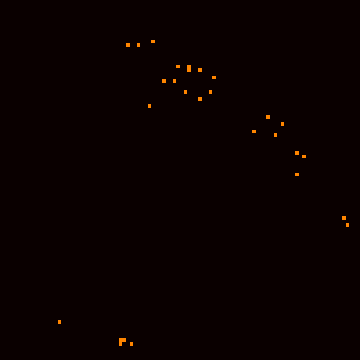
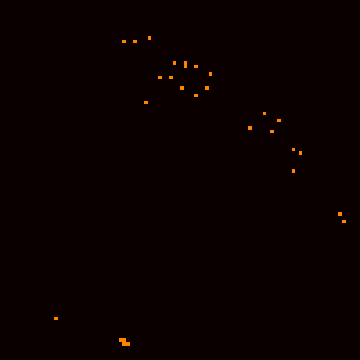
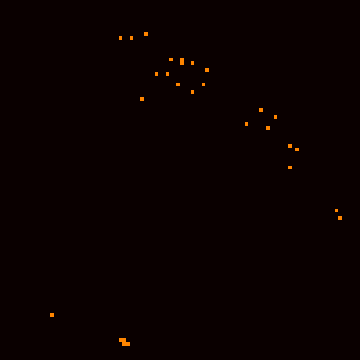
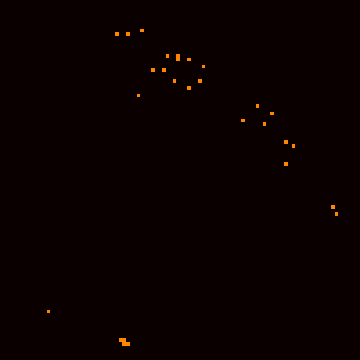
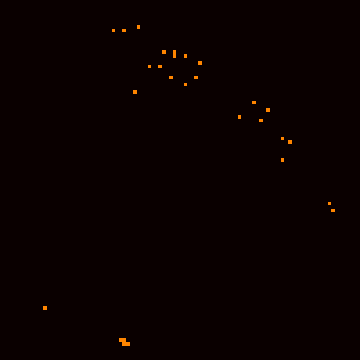
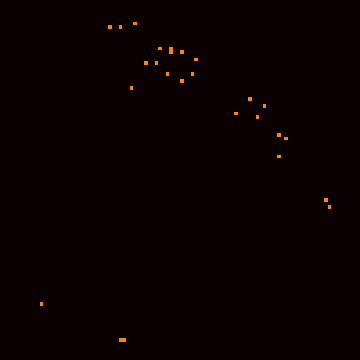
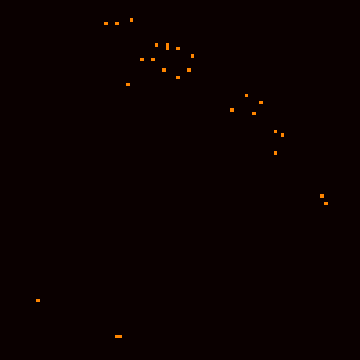
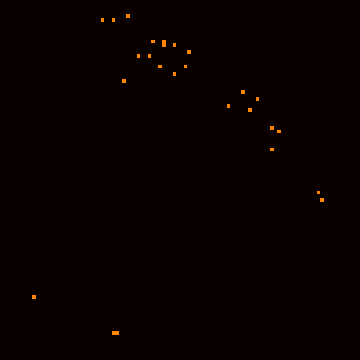
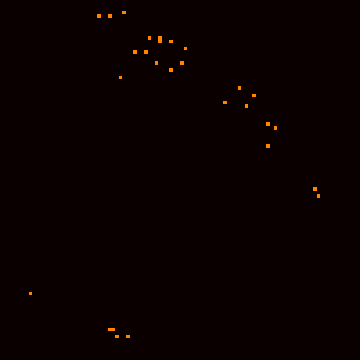
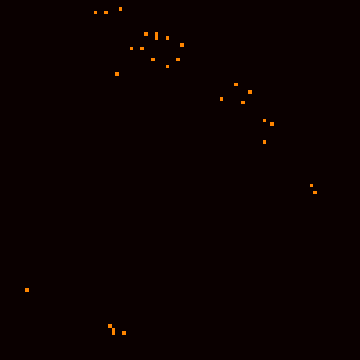
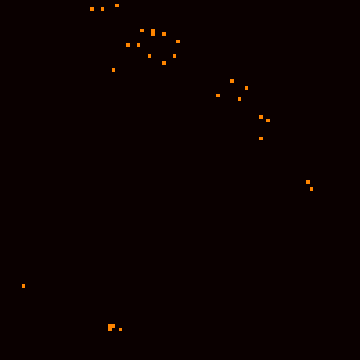
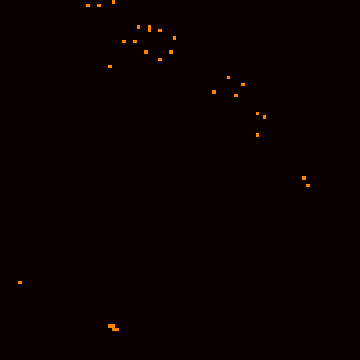
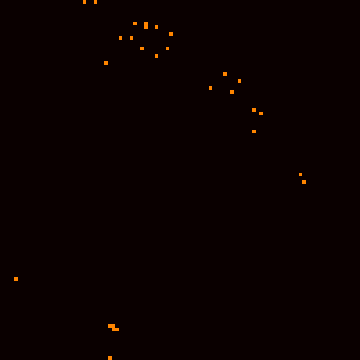
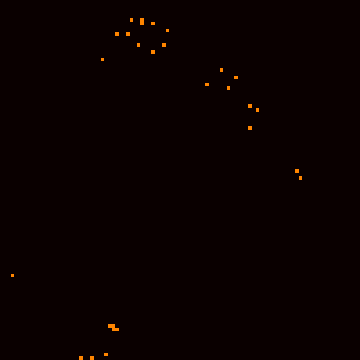
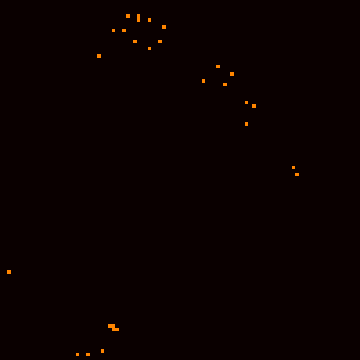
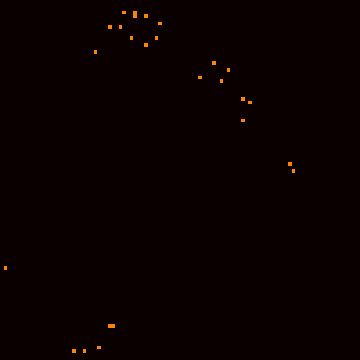
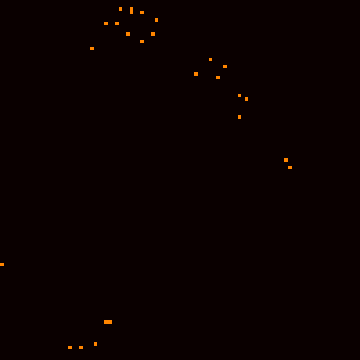
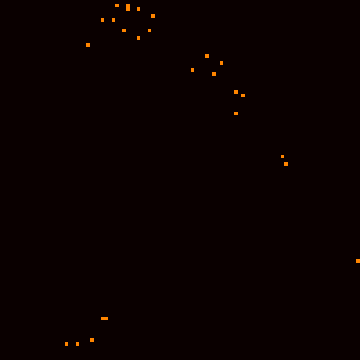
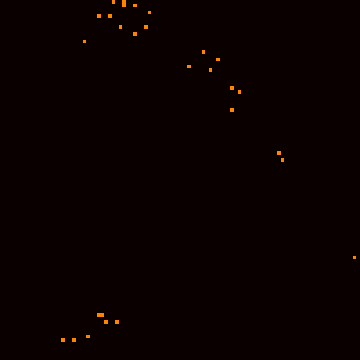
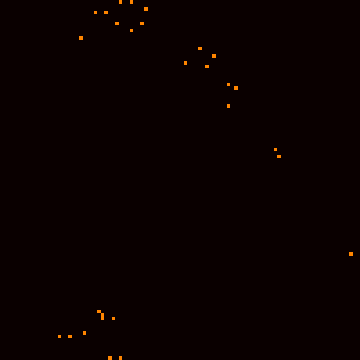
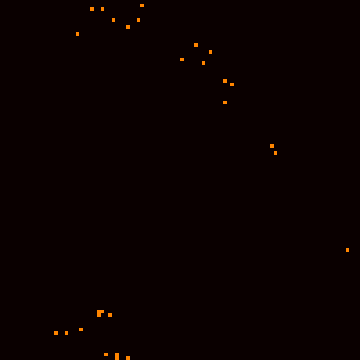
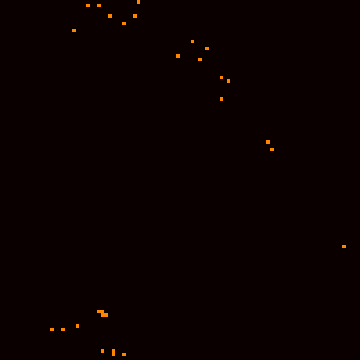
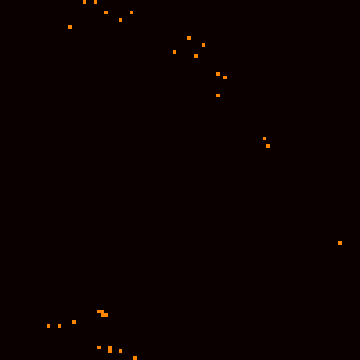
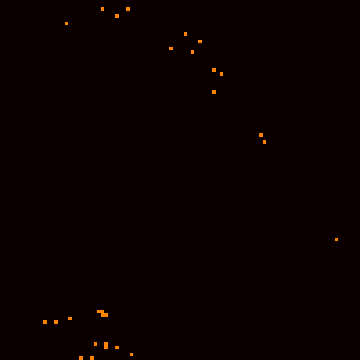
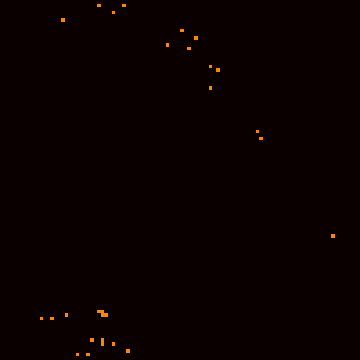
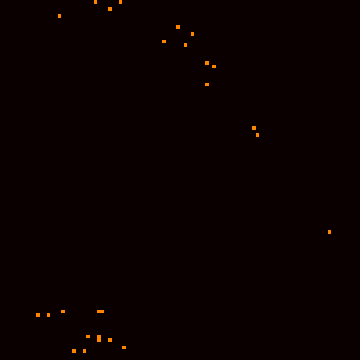
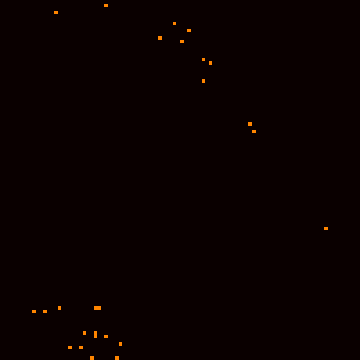
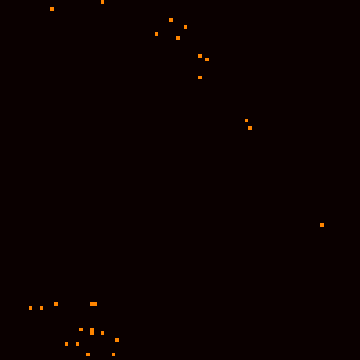
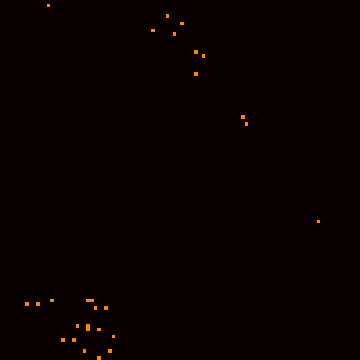
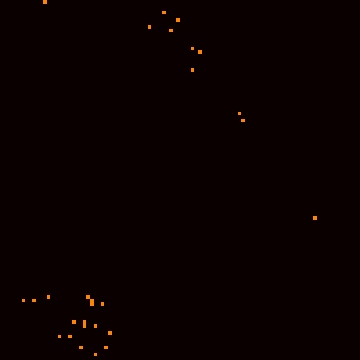
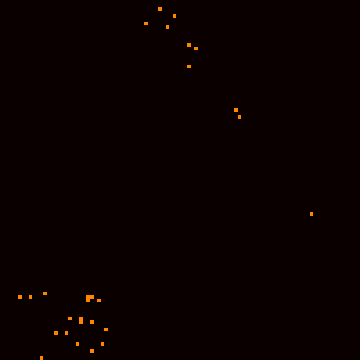
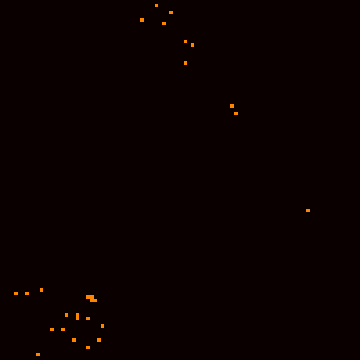
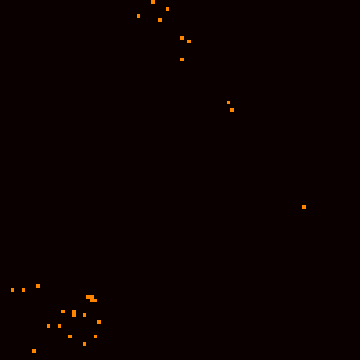
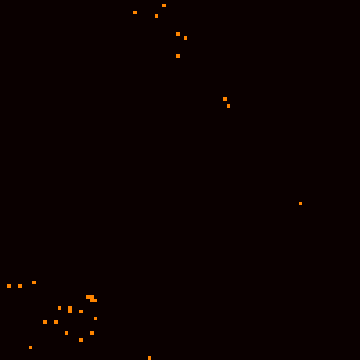
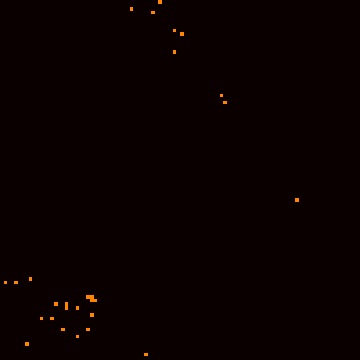
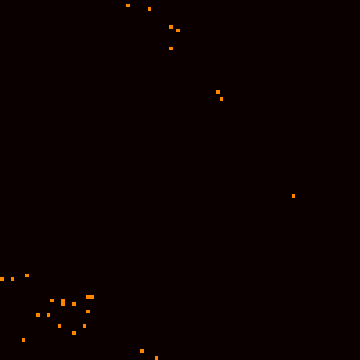
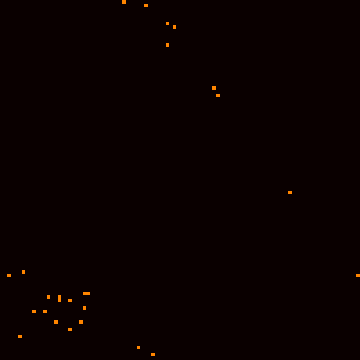
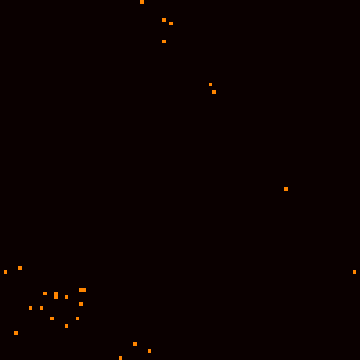
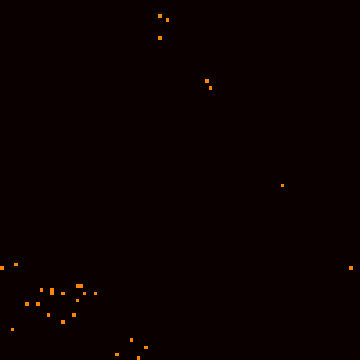
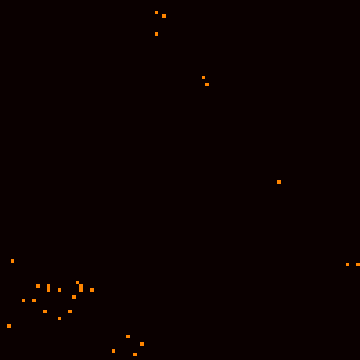
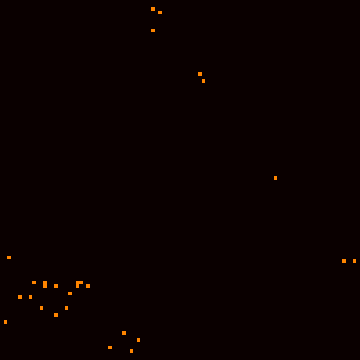
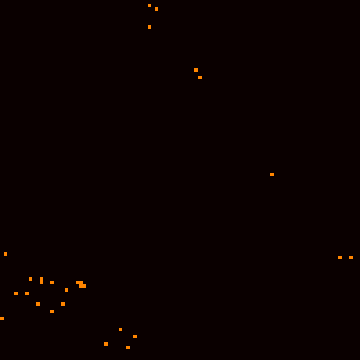
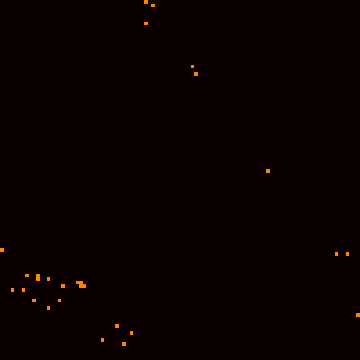
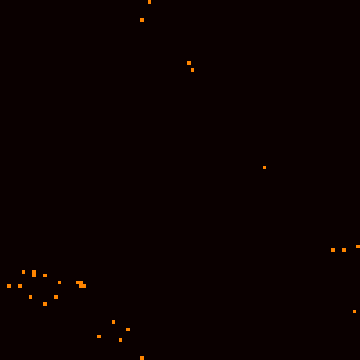
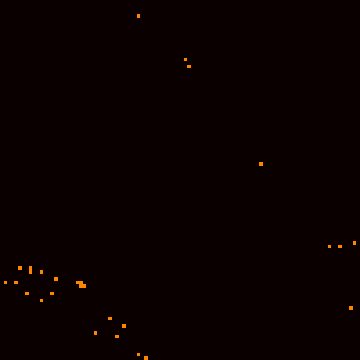
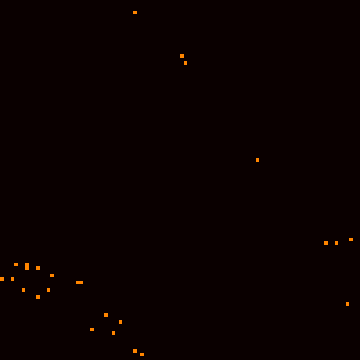
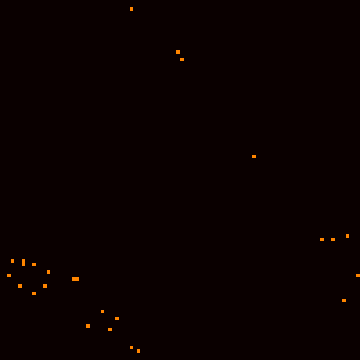
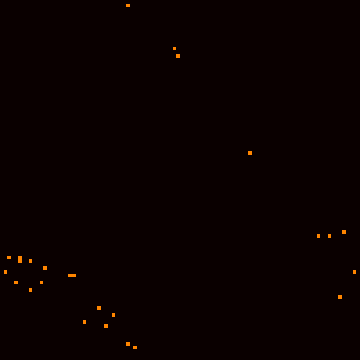
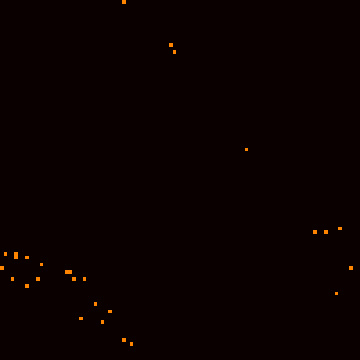
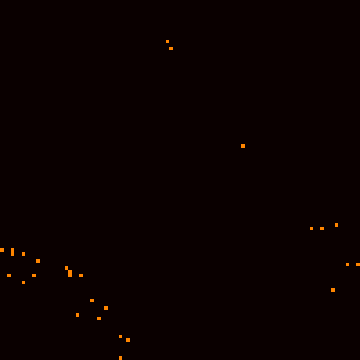
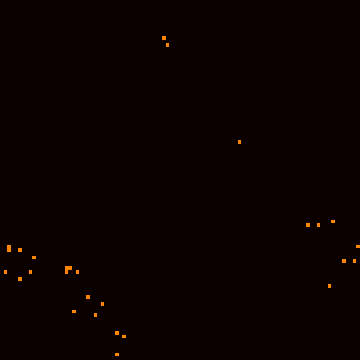
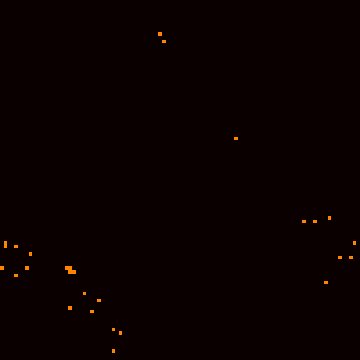
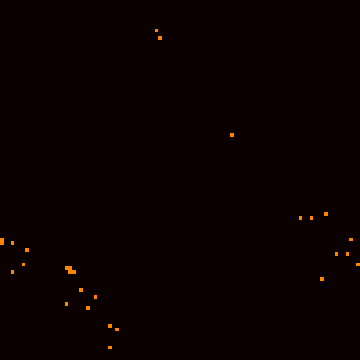
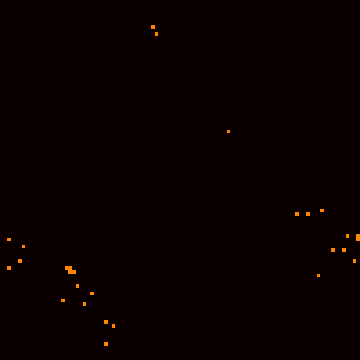
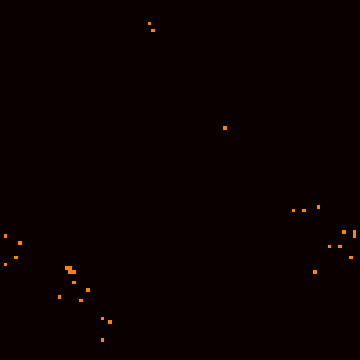
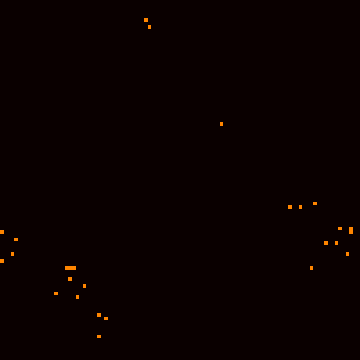
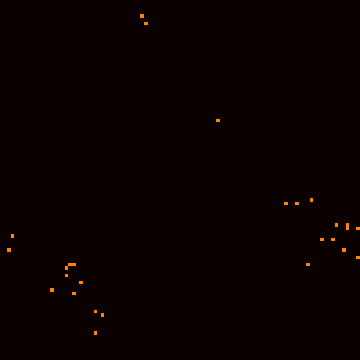
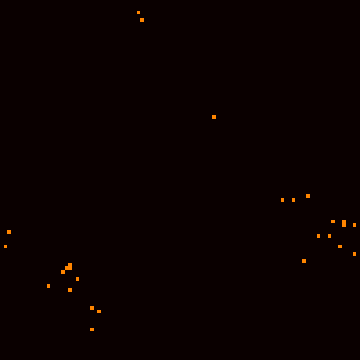
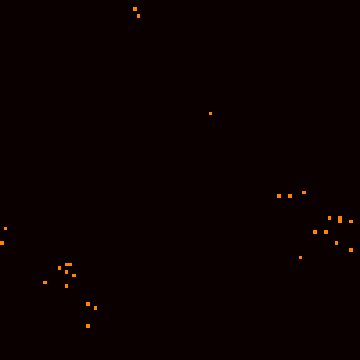
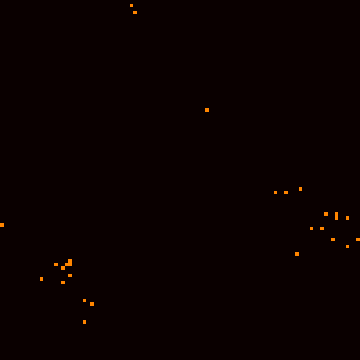
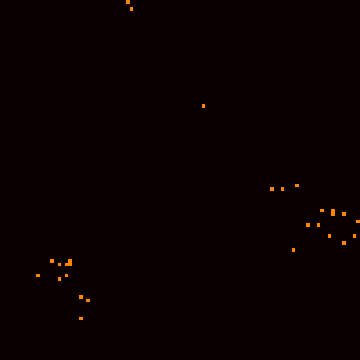
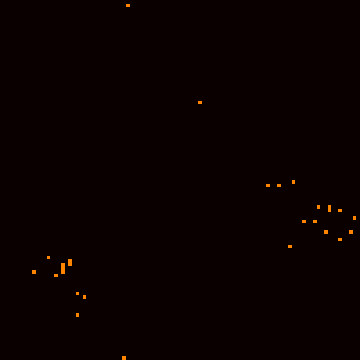
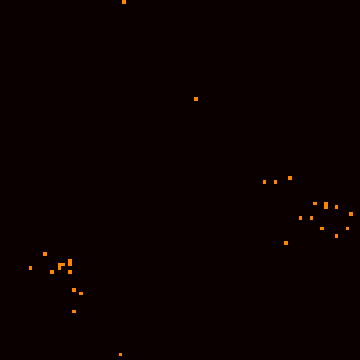
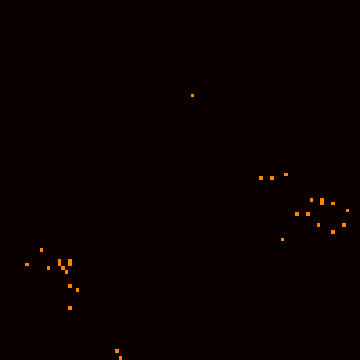
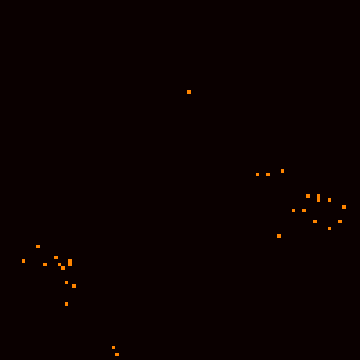
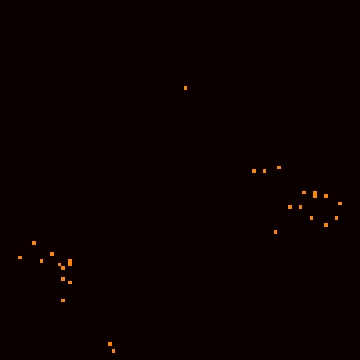
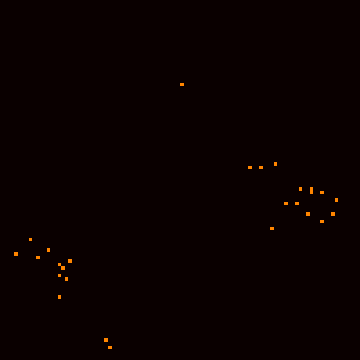
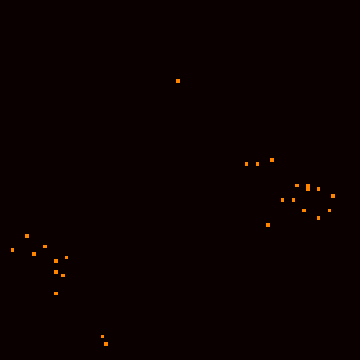
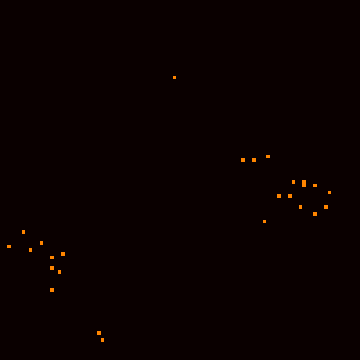
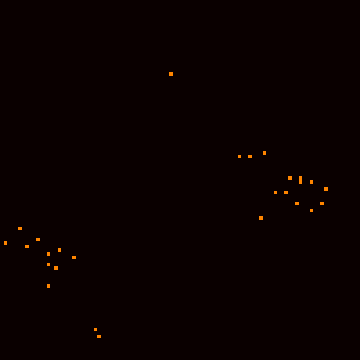
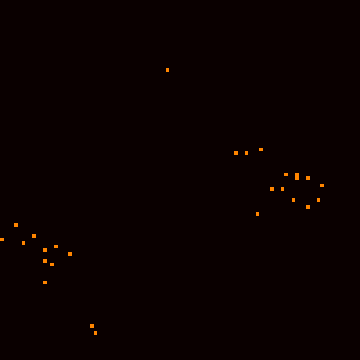
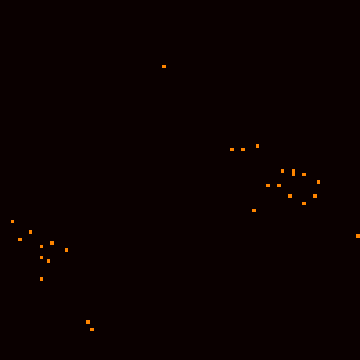
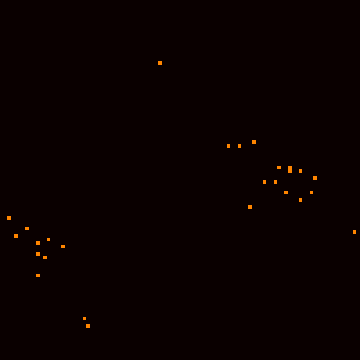
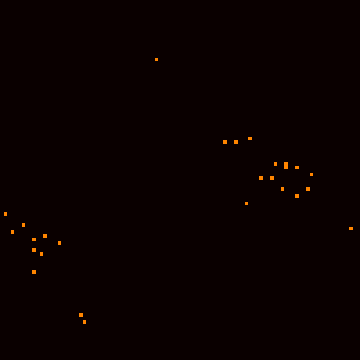
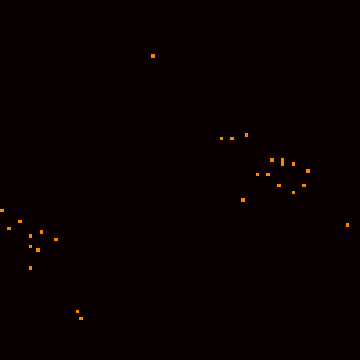
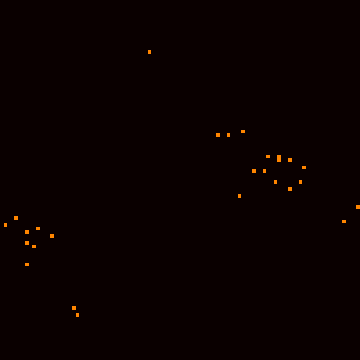
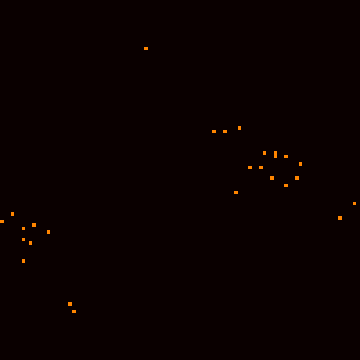
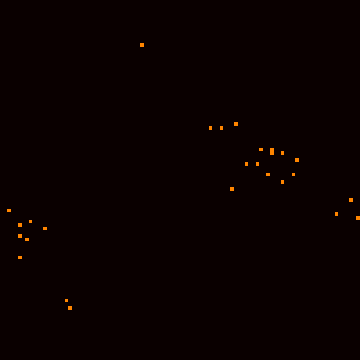
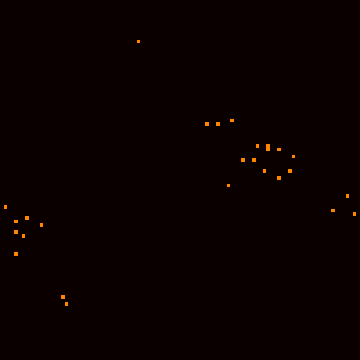
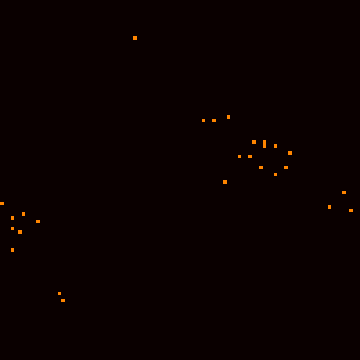
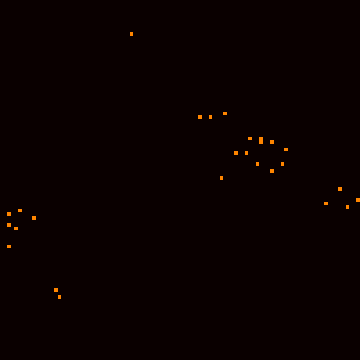
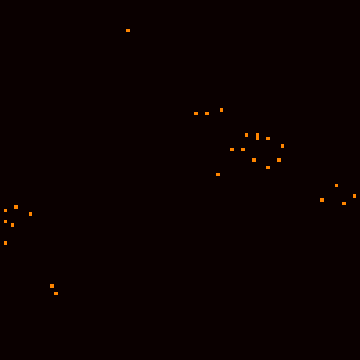
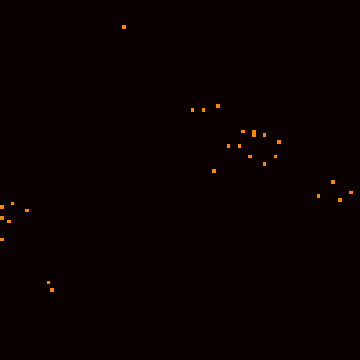
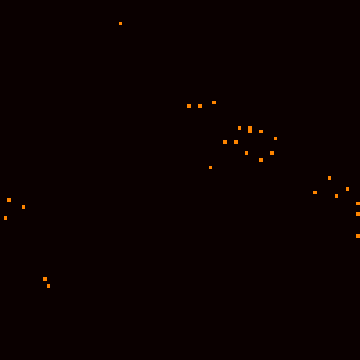
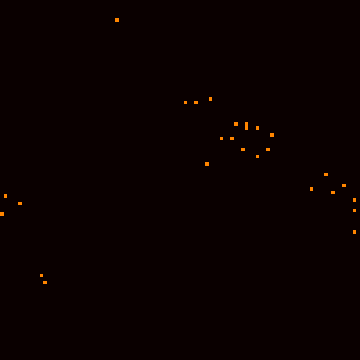
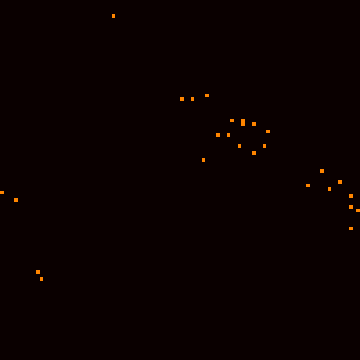
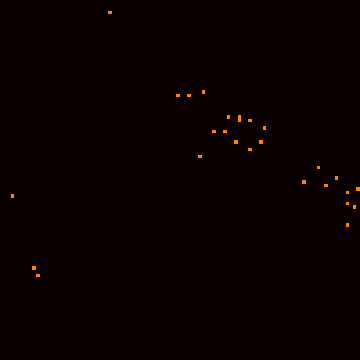
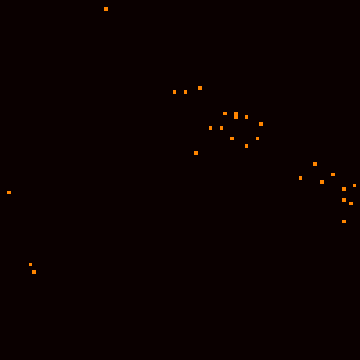
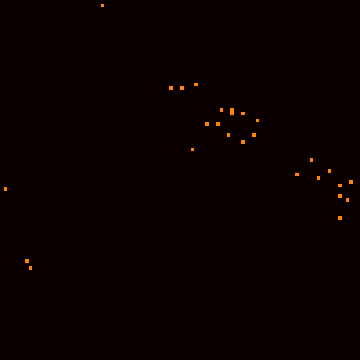
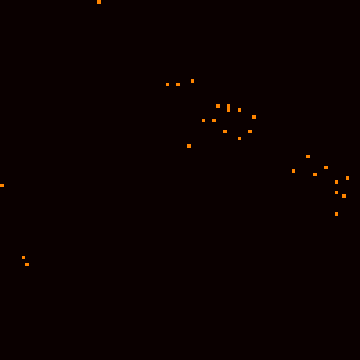
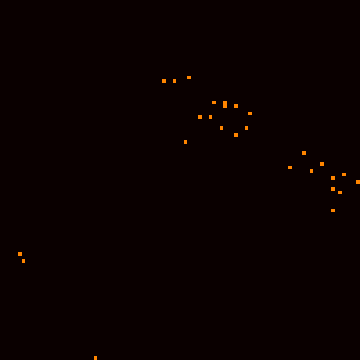
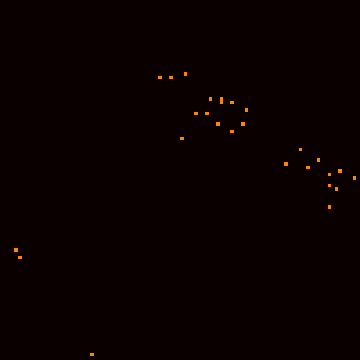
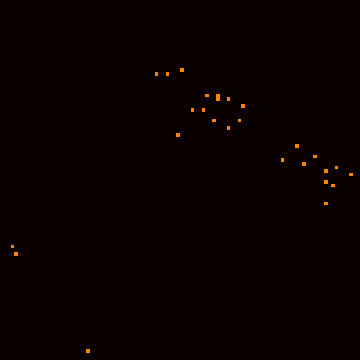
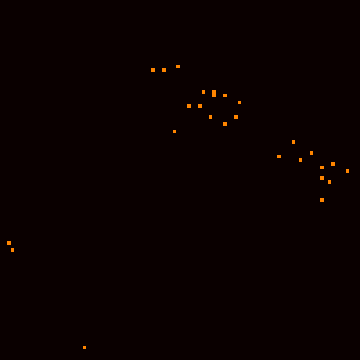
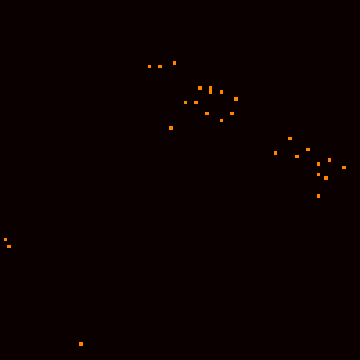
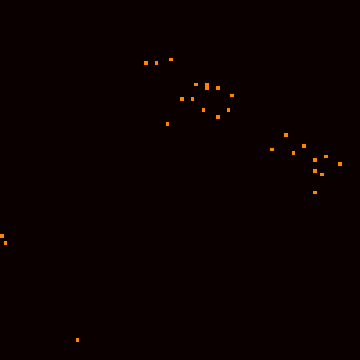
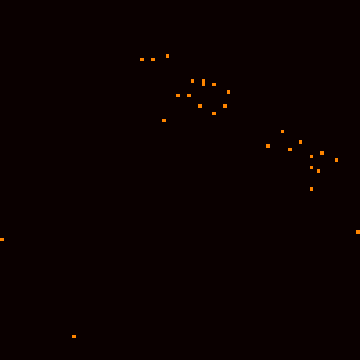
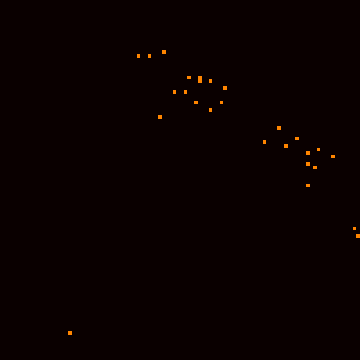
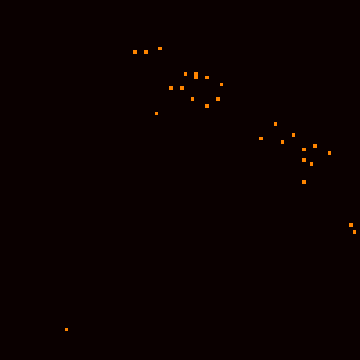
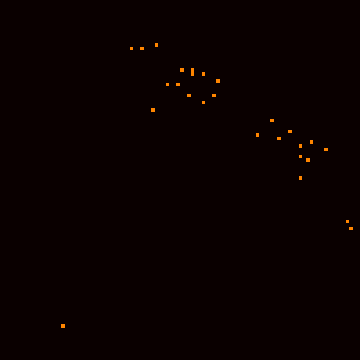

In [48]:
gr2, c2 = slime(extract_tribe(c,[5]));gr2